<a href="https://colab.research.google.com/github/Filoferro03/ProgettoDataIntensive/blob/main/000_DataIntensiveProgetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevedere il numero di calorie consumate da una persona durante un allenamento basandosi su misure biologiche

Progetto di Programmazione di Applicazione Data Intensive A.A. 2024/25

Ferretti Filippo, Ricci Nicholas

filippo.ferretti6@studio.unibo.it - nicholas.ricci3@studio.unibo.it

# Descrizione del progetto

L'obiettivo principale di questo progetto è lo sviluppo e la validazione di un modello di machine learning finalizzato alla predizione del consumo calorico durante l'attività fisica. A tal fine, verrà impiegato un dataset contenente attributi anagrafici (come genere, età, altezza e peso) e misurazioni fisiologiche rilevate durante l'esercizio (quali durata dell'attività, frequenza cardiaca e temperatura corporea).

Il problema in esame è un compito di regressione, dato che l'intento è prevedere un valore numerico continuo (le calorie consumate). Il progetto si articolerà nelle seguenti fasi fondamentali:

*   **Analisi esplorativa dei dati**: per comprendere le caratteristiche intrinseche del dataset e identificare le relazioni tra le variabili.
*   **Preparazione dei dati**: per rendere i dati idonei all'elaborazione da parte degli algoritmi di machine learning, includendo operazioni di pulizia, trasformazione e suddivisione.
*   **Addestramento e dalutazione dei modelli predittivi**: implementazione e confronto di due o più modelli di regressione al fine di individuare quello con le prestazioni ottimali.
*   **Analisi e interpretazione del modello selezionato**: per determinare i fattori più influenti sul dispendio energetico e comprenderne l'impatto.

Lo scopo ultimo è fornire uno strumento predittivo affidabile e, attraverso l'interpretazione dei risultati, acquisire una comprensione approfondita dei fattori che regolano il dispendio energetico durante l'esercizio fisico.

https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction/data

In [ ]:
%pip install lightgbm
%pip install xgboost
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns
import xgboost
import catboost
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
%matplotlib inline

In [ ]:
path = kagglehub.dataset_download("ruchikakumbhar/calories-burnt-prediction")
calories_dataset = pd.read_csv(path + "/calories.csv", dtype={"Gender": "category"})

## Descrizione iniziale del dataset

In [ ]:
calories_dataset.head(2)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0


In [ ]:
calories_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   User_ID     15000 non-null  int64   
 1   Gender      15000 non-null  category
 2   Age         15000 non-null  int64   
 3   Height      15000 non-null  float64 
 4   Weight      15000 non-null  float64 
 5   Duration    15000 non-null  float64 
 6   Heart_Rate  15000 non-null  float64 
 7   Body_Temp   15000 non-null  float64 
 8   Calories    15000 non-null  float64 
dtypes: category(1), float64(6), int64(2)
memory usage: 952.4 KB


Il dataset contiene un totale di 15.000 istanze e 9 variabili con la seguente struttura:
1. **User_ID**: Identificativo unico dell'utente
2. **Gender**: Genere dell'utente.
3. **Age**: Età in anni dell'utente.
4. **Height**: Altezza in centimetri dell'utente.
5. **Weight**: Peso in chilogrammi dell'utente.
6. **Duration**: Durata dell'allenamento in minuti.
7. **Heart_Rate**: Frequenza cardiaca media in battiti al minuto
8. **Body_Temp**: Temperatura corporea media in gradi centigradi.
9. **Calories**: Variabile **target** da predire in Kilocalorie.

L'analisi delle statistiche descrittive ottenute ci fornisce una panoramica iniziale della distribuzione e delle caratteristiche delle variabili presenti nel nostro dataset.  Come prima osservazione, è importante notare che tutte le variabili numeriche presentano 15.000 conteggi, indicando l'assenza di valori mancanti in tutte le colonne, il che semplifica notevolmente le fasi iniziali di pre-processing dei dati.

In [ ]:
print("\nPresenza di valori nulli: " + str(calories_dataset.isna().any().any()))


Presenza di valori nulli: False


In [ ]:
calories_dataset.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


### Variabili predittive (Age, Height, Weight, Duration, Heart_Rate, Body_Temp):

I valori medi e le deviazioni standard ci forniscono una misura della tendenza centrale e della dispersione per ciascuna variabile.
Ad esempio, l'età media degli utenti è di circa 42 anni, con una deviazione standard di quasi 17 anni, suggerendo una notevole variabilità nell'età del campione.
La durata media dell'allenamento è di circa 15.5 minuti, con una deviazione standard di 8.3 minuti.
I range di valori (minimo e massimo) appaiono plausibili per tutte le variabili nel contesto di un'attività fisica (es. età da 20 a 79 anni, altezza da 123 cm a 222 cm, durata allenamento da 1 a 30 minuti).
I quartili (25%, 50%, 75%) offrono ulteriori informazioni sulla distribuzione dei dati. Ad esempio, il 50% degli allenamenti ha una durata inferiore o uguale a 16 minuti, mentre il 75% ha una durata massima di 23 minuti.

### Variabile target (Calories):

Il valore medio di calorie consumate è di circa 89.54 kcal, con una deviazione standard di 62.46 kcal, indicando una dispersione significativa nel dispendio calorico registrato.
Il range dei valori va da un minimo di 1 kcal a un massimo di 314 kcal.
La distribuzione dei quartili (25% a 35 kcal, 50% a 79 kcal, 75% a 138 kcal) suggerisce una possibile asimmetria o variabilità nella distribuzione del consumo calorico, che sarà oggetto di ulteriori indagini attraverso analisi delle distribuzioni e visualizzazioni grafiche.

### Conclusione

In conclusione, le statistiche descrittive iniziali non rivelano anomalie macroscopiche o valori estremi irrealistici che richiedano una pulizia immediata dei dati, ad eccezione della variabile 'User_ID' che verrà eliminata in quanto identificativo unico per ogni utente e non predittivo del consumo calorico. Tuttavia, si è notato che la variabile 'Duration' presenta valori minimi molto bassi (1 minuto), il che potrebbe indicare la presenza di presunti allenamenti di durata decisamente breve per essere considerati affidabili o incidenti reali di dispendio calorico significativo. Questi valori anomali, sebbene numericamente validi, potrebbero influenzare l'accuratezza del modello e saranno oggetto di una fase di pulizia e filtraggio più approfondita nei passaggi successivi, come parte della preparazione dei dati.

# Analisi Esplorativa dei Dati
Questa sezione è dedicata all'esplorazione approfondita del dataset, con l'obiettivo di comprenderne le caratteristiche, individuare pattern, anomalie e relazioni tra le variabili, fornendo una base solida per le successive fasi di pre-processing e modellazione. Verranno riportate statistiche generali e distribuzioni delle variabili attraverso tabelle e grafici, con un adeguato commento dei risultati.

## Gestione variabili non informative

In questa fase preliminare dell'EDA, si procede all'identificazione e rimozione delle variabili che non apportano valore predittivo al modello, in accordo con l'analisi iniziale del dataset.
La colonna 'User_ID' è un identificativo unico dell'utente e non è informativa per la predizione del consumo calorico. Pertanto, viene rimossa dal dataset per semplificare le successive elaborazioni.

In [ ]:
calories_dataset = calories_dataset.drop(columns="User_ID")
calories_dataset.head(2)

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0


## Distribuzione delle variabili
Per una comprensione dettagliata della struttura dei dati, si analizza la distribuzione di ciascuna variabile singolarmente. Questo permette di identificare la forma delle distribuzioni, la presenza di outlier e la variabilità intrinseca di ogni caratteristica.

In [ ]:
def plot_single_scatterplot(dataframe, x_column, y_column, plot_color='lightsteelblue', xlabel="", ylabel="", figsize=(5, 5), title=None, point_size=20, alpha=0.6, show_grid=True):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x=dataframe[x_column], y=dataframe[y_column], data=dataframe, s=point_size, alpha=alpha, ax=ax, color=plot_color)
    sns.regplot(x=x_column, y=y_column, data=dataframe, scatter=False, color='red', line_kws={'linewidth': 2}, ax=ax)
    ax.set_ylim(bottom=0)
    if title is None:
        ax.set_title(f'Relazione tra {xlabel} e {ylabel}', fontsize=16)
    else:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    if show_grid:
        ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_boxplot_and_histogram(dataframe, column_name, plot_color, label="", bins=25, figsize=(9, 4), boxplot_title=None, hist_title=None):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    #boxplot
    sns.boxplot(x=dataframe[column_name], ax=axes[0], color=plot_color, width=0.4, showmeans=True, orient='v')
    clean_col_name = column_name.replace("_", " ")
    if boxplot_title is None:
        axes[0].set_title(f'Boxplot {label}', fontsize=14)
    else:
        axes[0].set_title(boxplot_title, fontsize=14)
    axes[0].set_xlabel(f'{label}'.strip(), fontsize=12)
    axes[0].set_ylabel('')
    axes[0].grid(True, linestyle='--', alpha=0.6, axis='x')
    #histogram
    sns.histplot(data=dataframe, x=column_name, bins=bins, edgecolor='black', color=plot_color, alpha=0.7, ax=axes[1], kde=True, stat='count')
    if hist_title is None:
        axes[1].set_title(f'Distribuzione {label}', fontsize=16)
    else:
        axes[1].set_title(hist_title, fontsize=16)
    axes[1].set_xlabel(f'{label}'.strip(), fontsize=12)
    axes[1].set_ylabel('Frequenza', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

### Gender

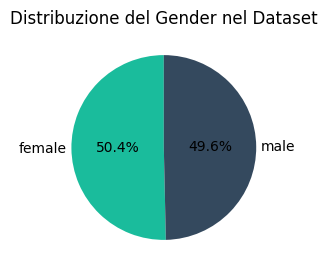

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
pie_ax = calories_dataset['Gender'].value_counts().plot.pie(ax=ax, autopct='%1.1f%%', startangle=90, pctdistance=0.5, labeldistance=1.05, colors=['#1ABC9C', '#34495E'])
ax.set_ylabel('')
ax.set_title('Distribuzione del Gender nel Dataset')
plt.show()

Il grafico a torta illustra la distribuzione della variabile 'Gender' nel dataset. Si osserva una ripartizione quasi paritaria tra femmine (50.4%) e maschi (49.6%), indicando un buon bilanciamento della variabile.

### Età

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


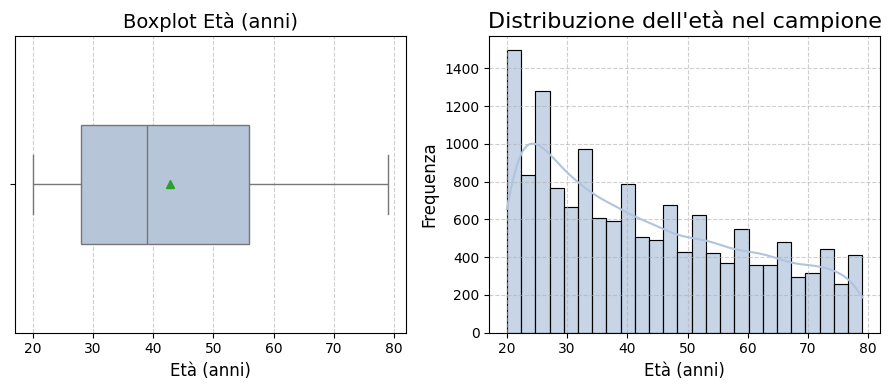

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset, column_name='Age', plot_color='lightsteelblue', label='Età (anni)', hist_title="Distribuzione dell'età nel campione")

I grafici relativi all'Età mostrano una distribuzione che tende ad essere leggermente asimmetrica a destra, con una maggiore concentrazione di individui nelle fasce di età più giovani.

L'istogramma conferma che la maggior parte degli utenti ha un'età compresa tra i 20 e i 30 anni, con una frequenza che diminuisce progressivamente all'aumentare dell'età.

Il boxplot indica che l'età mediana è attorno ai 40 anni, in linea con la media di 42 anni già osservata nelle statistiche descrittive. Il range interquartile (IQR) mostra che il 50% degli utenti ha un'età compresa tra 28 e 56 anni. I valori minimo e massimo (20 e 79 anni) sono ragionevoli e non suggeriscono la presenza di outlier estremi o errati per questa variabile. La distribuzione è abbastanza ampia, indicando una buona rappresentazione di diverse fasce di età nel dataset.

### Altezza

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


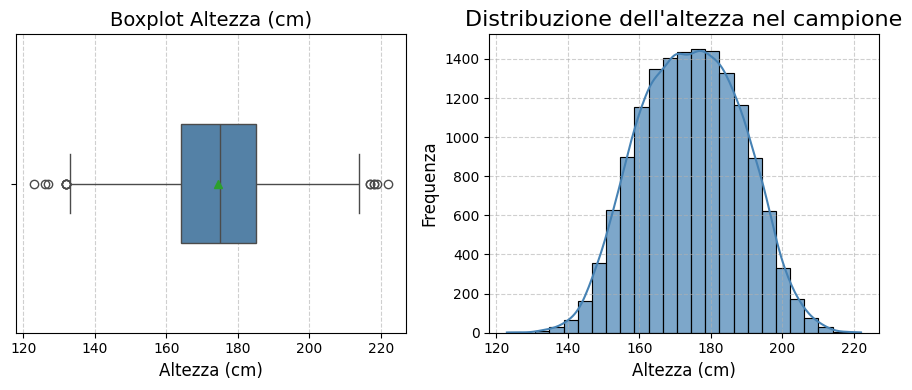

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset, column_name='Height', plot_color='steelblue', label='Altezza (cm)', hist_title="Distribuzione dell'altezza nel campione")

I grafici per l'Altezza mostrano una distribuzione che appare simmetrica e approssimativamente normale.

L'istogramma evidenzia una concentrazione di altezze attorno alla media, con una diminuzione della frequenza allontanandosi dal centro, tipica di una distribuzione a campana.

Il boxplot indica che l'altezza mediana è di circa 170 cm, in linea con la media (174.46 cm) osservata nelle statistiche descrittive. Il 50% degli individui ha un'altezza compresa tra 164 cm e 185 cm.

Sono presenti alcuni outlier, visibili come punti al di fuori dei "baffi" del boxplot (attorno a 120-130 cm e 210-220 cm). Questi valori rappresentano altezze estreme rispetto alla maggioranza del campione. Tuttavia, dato che i valori sono plausibili per esseri umani (sebbene rari), quindi non verranno rimossi.

La distribuzione generale dell'altezza nel dataset è coerente con quella attesa per una popolazione umana.

### Peso

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


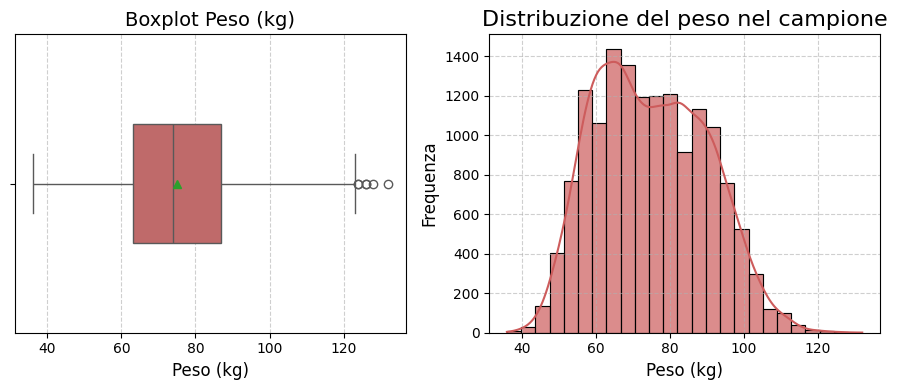

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset, column_name='Weight', plot_color='indianred', label='Peso (kg)', hist_title="Distribuzione del peso nel campione")

I grafici per il Peso mostrano una distribuzione che, analogamente all'altezza, appare abbastanza simmetrica e vicina a una distribuzione normale.

L'istogramma indica una concentrazione di pesi attorno alla media, con una diminuzione della frequenza per valori più estremi, riflettendo una distribuzione a campana.

Il boxplot evidenzia che il peso mediano è di circa 75 kg, molto vicino alla media (74.97 kg) riscontrata nelle statistiche descrittive. Il 50% degli individui pesa tra 63 kg e 87 kg.

Mentre si osservano alcuni outlier nella parte alta della distribuzione (attorno ai 120-130 kg). Anche in questo caso, pur essendo valori estremi, sono plausibili per la popolazione umana e verranno mantenuti.

La variabile 'Peso' mostra una buona variabilità e una distribuzione ragionevole.

### Durata

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


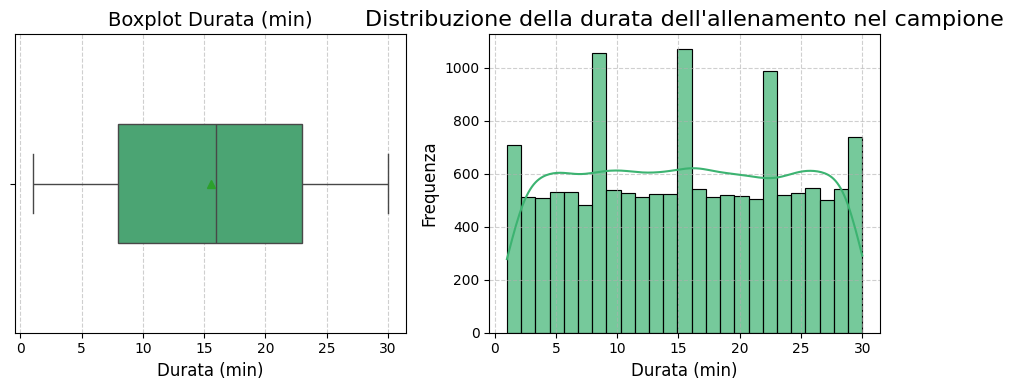

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset, column_name='Duration', plot_color='mediumseagreen', label='Durata (min)', hist_title="Distribuzione della durata dell'allenamento nel campione")

I grafici per la Durata dell'allenamento mostrano una distribuzione non uniforme, con picchi di frequenza a intervalli regolari.

L'istogramma rivela una distribuzione multimodale, con diverse barre di frequenza più alte. Questo suggerisce che gli allenamenti tendono ad avere durate preferenziali o "arrotondate", come 10, 15, 20 e 30 minuti.

Il boxplot, nonostante mostri un intervallo interquartile (IQR) compreso tra circa 8 e 23 minuti, non cattura pienamente la complessità della distribuzione a causa della sua natura aggregata. Il valore mediano si aggira intorno ai 16 minuti, coerentemente con la media di 15.53 minuti già osservata.

Come discusso in precedenza, il valore minimo di 1 minuto per la durata dell'allenamento può essere considerato sospetto o poco significativo ai fini della predizione del consumo calorico. Sebbene non sia un outlier in senso statistico (cioè un valore estremo), è un'osservazione che indica una durata decisamente breve per un allenamento affidabile e incidente sul dispendio energetico. Questi punti verranno considerati per una successiva fase di pulizia o filtraggio dei dati.

### Frequenza cardiaca media

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


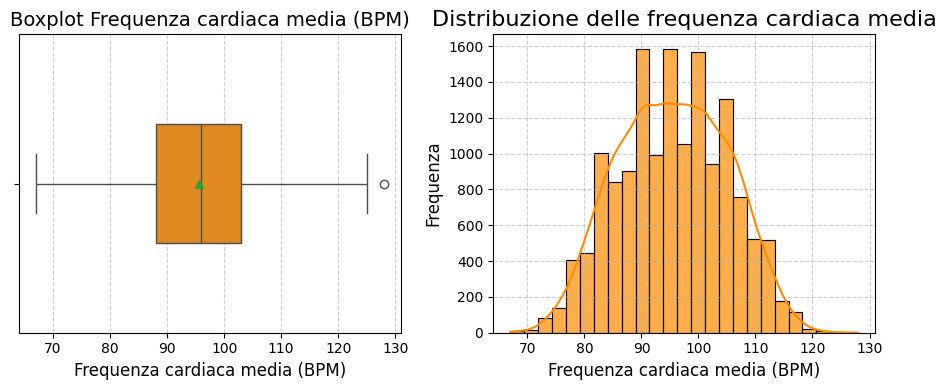

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset, column_name='Heart_Rate', plot_color='darkorange', label='Frequenza cardiaca media (BPM)', hist_title="Distribuzione delle frequenza cardiaca media")

I grafici per la Frequenza cardiaca media mostrano una distribuzione che si concentra attorno a un valore centrale, pur presentando una coda a sinistra e alcuni outlier a destra.

L'istogramma indica che la maggior parte delle misurazioni si trova tra 90 e 100 BPM, suggerendo un'intensità di allenamento moderata per la maggior parte del campione.

Il boxplot evidenzia una mediana attorno ai 95 BPM, che è in linea con la media (95.52 BPM) già osservata. Il 50% delle frequenze cardiache rientra tra 88 e 103 BPM.

Si osservano outlier superiori a circa 125 BPM, che potrebbero indicare allenamenti ad alta intensità o picchi di sforzo. Più interessante, il valore minimo si attesta attorno ai 70 BPM. Sebbene 70 BPM sia un valore plausibile per la frequenza cardiaca a riposo per molti individui, è un valore relativamente basso per essere la frequenza media durante un'attività fisica, soprattutto se finalizzata a bruciare calorie. Come per la 'Duration', la presenza di frequenze cardiache medie così basse potrebbe indicare sessioni di attività fisica di intensità molto ridotta o scenari meno "attivi" di quanto atteso per un allenamento, e meriterà un'ulteriore valutazione in fase di pulizia dei dati per assicurare l'affidabilità del dataset per la predizione del consumo calorico.

### Temperatura corporea media

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


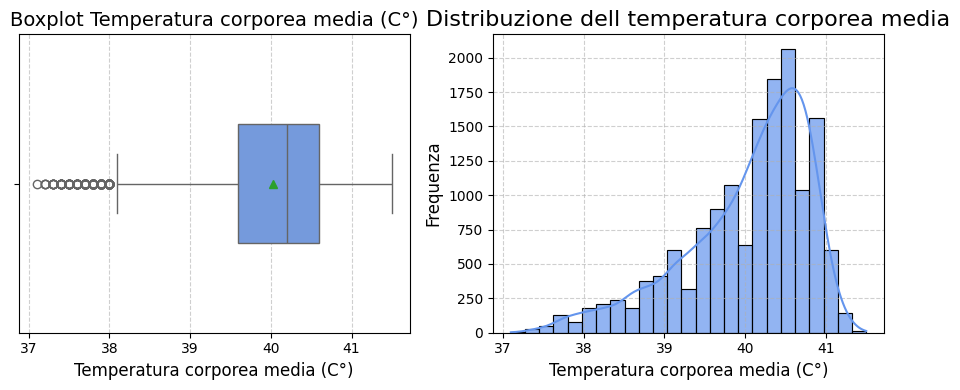

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset, column_name='Body_Temp', plot_color='cornflowerblue', label='Temperatura corporea media (C°)', hist_title="Distribuzione dell temperatura corporea media")

I grafici per la Temperatura corporea media mostrano una distribuzione che appare quasi normale, fortemente concentrata attorno al valore medio, con una leggera asimmetria verso sinistra.

L'istogramma rivela che la maggior parte delle misurazioni di temperatura corporea media si situa tra 40°C e 41°C. Questo intervallo è coerente con l'aumento della temperatura corporea durante un'attività fisica significativa.

Il boxplot conferma una mediana prossima ai 40°C, in linea con la media (40°C) già rilevata. Il 50% delle misurazioni si trova tra 39.6°C e 40.6°C.

Si nota la presenza di numerosi outlier nella parte inferiore della distribuzione, con temperature che si estendono fino a circa 37°C. Sebbene 37°C rientri nella norma per la temperatura corporea a riposo, questi valori, in un contesto di "allenamento", potrebbero indicare sessioni a bassissima intensità, o forse errori di misurazione/registrazione, similmente a quanto osservato per la durata e la frequenza cardiaca media. La loro presenza sarà valutata successivamente in fase di pulizia dei dati per determinarne l'impatto sulla robustezza del modello.

### Calorie

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


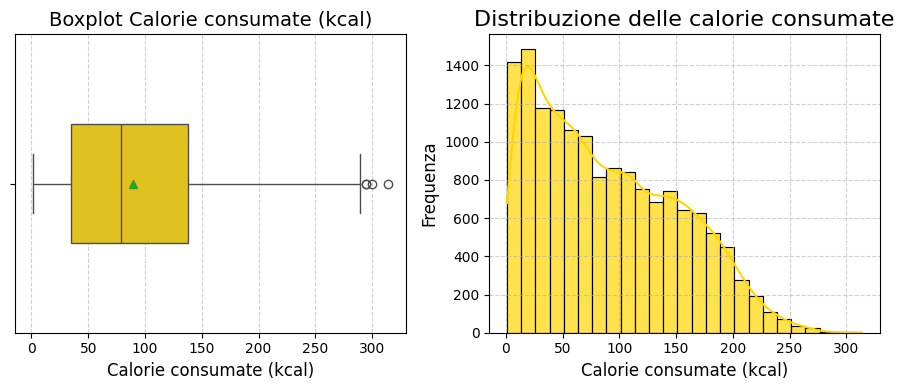

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset, column_name='Calories', plot_color='gold', label='Calorie consumate (kcal)',hist_title="Distribuzione delle calorie consumate")

I grafici per la variabile calorie consumate che rappresenta il nostro target di predizione, mostrano una distribuzione chiaramente asimmetrica a destra.

L'istogramma rivela una concentrazione elevata di valori di calorie consumate nella fascia bassa (0-50 kcal), con la frequenza che diminuisce man mano che il valore delle calorie aumenta. Questo indica che la maggior parte delle sessioni di allenamento nel dataset comporta un consumo calorico relativamente basso.

Il boxplot conferma questa asimmetria: la mediana (circa 79 kcal) è significativamente inferiore alla media (89.54 kcal) e si trova verso il limite inferiore del box. Il 50% delle calorie consumate rientra tra 35 kcal e 138 kcal.

Sono presenti numerosi outlier nella parte alta della distribuzione, indicando un certo numero di sessioni di allenamento con un dispendio calorico molto elevato (fino a 314 kcal).

La variabilità complessiva della variabile è adeguata per un problema di regressione.

## Analisi delle relazioni tra variabili
Questa fase si concentrerà sull'esame delle relazioni tra la variabile target ('Calories') e le variabili predittive, così come le interrelazioni tra le variabili predittive stesse.

### Preparazione variabili per analisi di correlazione
Prima di procedere con il calcolo delle correlazioni, è necessario convertire le variabili categoriche in un formato numerico, poiché la correlazione è una misura applicabile a variabili quantitative.
Per la variabile 'Gender', è stato applicato il One-Hot Encoding per trasformarla in rappresentazioni numeriche binarie.
Questo processo ha creato le nuove colonne 'Female' e 'Male'. Ciascuna colonna indica la presenza (1) o assenza (0) della specifica categoria di genere.

In [ ]:
calories_dataset_encoded = pd.get_dummies(calories_dataset, columns=['Gender'], drop_first=False)
calories_dataset_encoded = calories_dataset_encoded.rename(columns={'Gender_female': 'Female', 'Gender_male': 'Male'})
calories_dataset_encoded['Female'] = calories_dataset_encoded['Female'].astype(int)
calories_dataset_encoded['Male'] = calories_dataset_encoded['Male'].astype(int)
calories_dataset_encoded.head(2)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Female,Male
0,68,190.0,94.0,29.0,105.0,40.8,231.0,0,1
1,20,166.0,60.0,14.0,94.0,40.3,66.0,1,0


### Matrice di correlazione

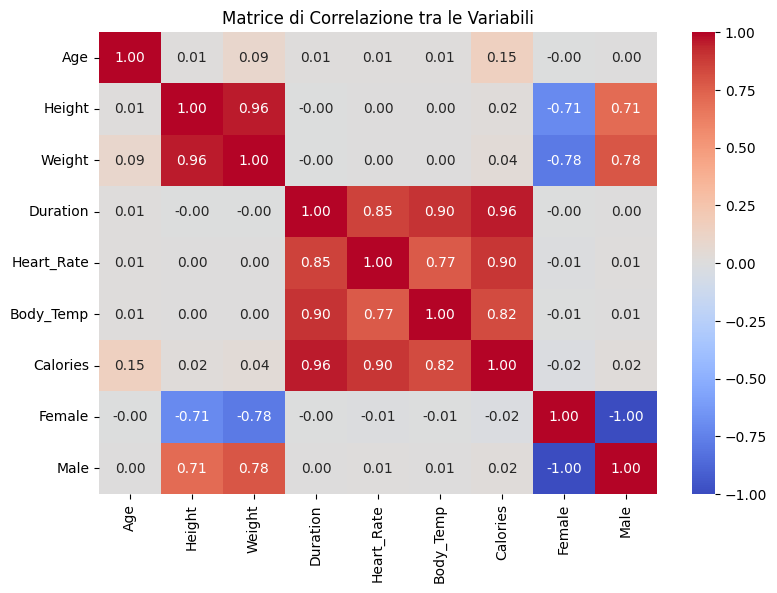

In [ ]:
plt.figure(figsize=(9, 6))
correlation_matrix = calories_dataset_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice di Correlazione tra le Variabili')
plt.show()

La heatmap della matrice di correlazione offre una visione chiara delle relazioni lineari tra tutte le variabili numeriche del dataset, con valori che vanno da -1 a 1.

Concentrandosi sulla variabile target 'Calories', si osserva una correlazione estremamente forte e positiva con 'Duration' (0.96), 'Heart_Rate' (0.90) e 'Body_Temp' (0.82), indicando che queste sono i predittori più influenti, come atteso in un contesto di attività fisica. 'Age' mostra una correlazione debole ma positiva (0.15), mentre 'Height', 'Weight' e le variabili di genere codificate ('Female': -0.02, 'Male': 0.02) presentano correlazioni quasi nulle con 'Calories', suggerendo un impatto lineare trascurabile.

Per quanto riguarda le interrelazioni tra le variabili predittive, si nota una forte correlazione tra 'Heart_Rate' e 'Body_Temp' con 'Duration' (rispettivamente 0.85 e 0.90), il che è fisiologicamente coerente. Analogamente, 'Heart_Rate' e 'Body_Temp' sono fortemente correlate tra loro (0.77). È fondamentale evidenziare l'elevata multicollinearità tra 'Height' e 'Weight' (0.96).

Queste osservazioni implicano che 'Duration', 'Heart_Rate' e 'Body_Temp' saranno predittori chiave per il modello. La forte multicollinearità tra 'Height' e 'Weight' dovrà essere gestite in fase di preparazione dei dati per ottimizzare la stabilità e l'interpretabilità del modello di regressione.

Si procede ora con la visualizzazione tramite grafici a dispersione delle relazioni tra la variabile target 'Calories' e le variabili predittive che hanno mostrato le correlazioni più significative, come identificato dalla matrice di correlazione e un'esservazione anche sull'importanza della variabile 'Gender' all'interno del nostro campione.

#### Calorie vs Durata

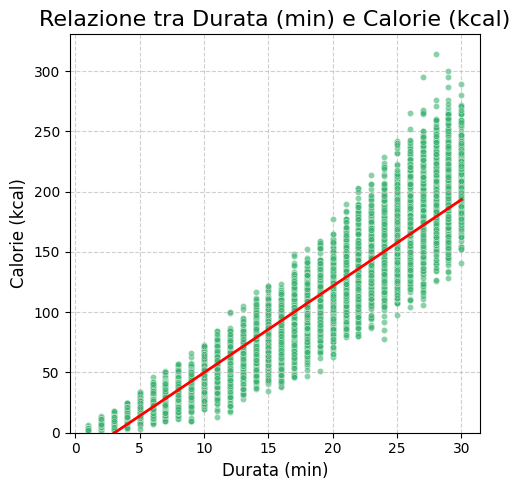

In [ ]:
plot_single_scatterplot(dataframe=calories_dataset, x_column='Duration', y_column='Calories', plot_color='mediumseagreen', xlabel='Durata (min)', ylabel='Calorie (kcal)')

Il grafico tra Durata dell'allenamento e Calorie consumate conferma visivamente la relazione estremamente forte e positiva già evidenziata dalla matrice di correlazione (0.96).

I punti si allineano molto strettamente lungo una retta, indicando una relazione quasi perfettamente lineare tra la durata dell'allenamento e le calorie bruciate. All'aumentare della durata, il consumo calorico aumenta proporzionalmente.

È possibile notare come anche per durate molto brevi (es. 1-5 minuti), ci sia un dispendio calorico non nullo, il che è fisiologicamente atteso. Tuttavia, l'affidabilità di queste misurazioni per durate estremamente ridotte, come discusso precedentemente potrebbe essere limitata.

#### Calorie vs Frequenza cardiaca media

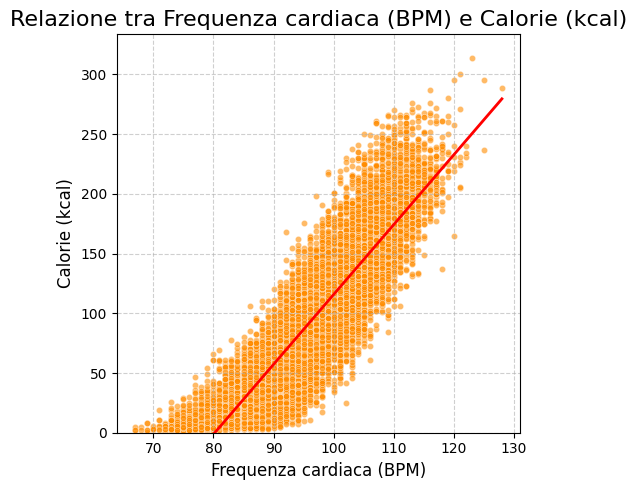

In [ ]:
plot_single_scatterplot(dataframe=calories_dataset, x_column='Heart_Rate', y_column='Calories', plot_color='darkorange', xlabel='Frequenza cardiaca (BPM)', ylabel='Calorie (kcal)')

Anche il grafico tra la frequenza cardiaca media e le calorie consumate conferma visivamente la forte correlazione positiva (0.90).

I punti tendono a seguire una chiara tendenza lineare positiva: all'aumentare della frequenza cardiaca media, aumenta anche il consumo calorico.

La retta di regressione si adatta bene alla nuvola di punti, indicando una relazione lineare robusta.

#### Calorie vs Temperatura corporea media

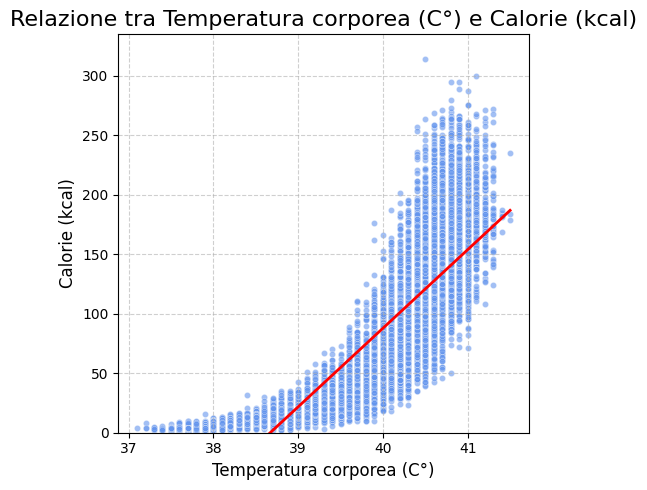

In [ ]:
plot_single_scatterplot(dataframe=calories_dataset, x_column='Body_Temp', y_column='Calories', plot_color='cornflowerblue', xlabel='Temperatura corporea (C°)', ylabel='Calorie (kcal)')

Il grafico tra la temperatura corporea media e le calorie consumate illustra una forte correlazione positiva, come indicato dal coefficiente di Pearson di 0.82.

Si osserva una chiara tendenza lineare positiva: all'aumentare della temperatura corporea media durante l'attività, aumenta anche il dispendio calorico.

La densità dei punti è maggiore nell'intervallo di temperatura più comune (tra 40°C e 41°C), coerentemente con la distribuzione osservata precedentemente.

Analogamente alle osservazioni per la durata e la frequenza cardiaca media, i valori di temperatura corporea più bassi (vicini a 37°C) si associano a un consumo calorico ridotto, rafforzando l'ipotesi di sessioni di attività di minore intensità o anomalie da considerare successivamente.

#### Calorie consumate in funzione del genere

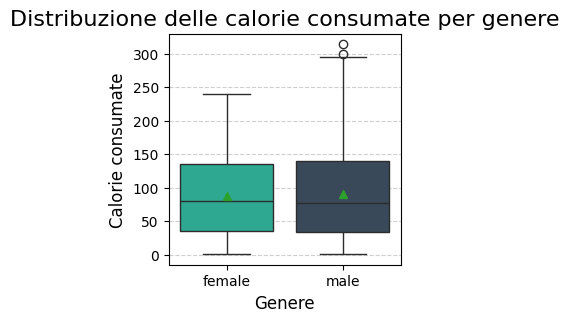

In [ ]:
plt.figure(figsize=(3, 3))
sns.boxplot(x='Gender', y='Calories', data=calories_dataset, hue='Gender', palette={'female': '#1ABC9C', 'male': '#34495E'}, showmeans=True)
plt.title('Distribuzione delle calorie consumate per genere', fontsize=16)
plt.xlabel('Genere', fontsize=12)
plt.ylabel('Calorie consumate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.show()

Il boxplot illustra la distribuzione delle calorie consumate per i due generi ('Female' e 'Male').

Visivamente, le distribuzioni mediane e gli intervalli interquartili appaiono molto simili per entrambi i generi. Ciò suggerisce che, in media, non vi è una differenza sostanziale nel consumo calorico tra femmine e maschi nel campione analizzato.

Questa osservazione è coerente con i coefficienti di correlazione quasi nulli (-0.02 per 'Female' e 0.02 per 'Male') riscontrati nella matrice di correlazione, i quali indicavano una relazione lineare trascurabile tra il genere e le calorie bruciate.

Si osserva la presenza di outlier nella parte alta della distribuzione per il genere maschile, indicando sessioni di allenamento con un dispendio calorico molto elevato per alcuni individui maschi.

In conclusione, il genere da solo non sembra essere un fattore determinante per una grande differenza nel consumo calorico per la maggior parte degli individui nel dataset.

## Pre-processing dei dati

Durante l'analisi esplorativa, sono state identificate alcune osservazioni che, pur rientrando nei range plausibili dei valori misurati, potrebbero rappresentare attività fisiche di intensità o durata non significative per l'obiettivo di predire il consumo calorico.

Nello specifico:

*  **Durata dell'allenamento**: Si sono notati valori minimi di 1 minuto. Allenamenti così brevi potrebbero non generare un dispendio calorico rappresentativo o potrebbero essere incidenti di misurazione.

*  **Frequenza cardiaca media**: I valori minimi si avvicinano alla frequenza cardiaca a riposo (circa 70 BPM). Un'attività fisica intesa a bruciare calorie dovrebbe generalmente elevare la frequenza cardiaca oltre questi livelli.

*  **Temperatura corporea media**: Similmente, i valori più bassi tendono verso la temperatura corporea a riposo (circa 37°C).

Per garantire che il modello venga addestrato su dati che rappresentano effettivamente sessioni di allenamento significative e per migliorare l'affidabilità delle predizioni, si è scelto di applicare un filtraggio per rimuovere le istanze che ricadono al di sotto di determinate soglie considerate minime per un'attività fisica rilevante ai fini del consumo calorico.

Si deciderà di filtrare le righe dove:
* la durata è inferiore a 3 minuti,
* la frequenza cardiaca media è inferiore a 80 BPM,
* la temperatura corporea media è inferiore a 38°C.

In [ ]:
initial_rows = calories_dataset_encoded.shape[0]
calories_dataset_cleaned = calories_dataset_encoded[
    (calories_dataset_encoded['Duration'] >= 3) &
    (calories_dataset_encoded['Heart_Rate'] >= 80) &
    (calories_dataset_encoded['Body_Temp'] >= 38)
]
filtered_rows = calories_dataset_cleaned.shape[0]
print(f"Numero di righe iniziali: {initial_rows}")
print(f"Numero di righe dopo il filtraggio: {filtered_rows}")
print(f"Numero di righe rimosse: {initial_rows - filtered_rows}")

Numero di righe iniziali: 15000
Numero di righe dopo il filtraggio: 13877
Numero di righe rimosse: 1123


# Preparazione dei Dati

### Mappatura della variabile Gender

In [ ]:
calories_dataset_cleaned = calories_dataset_cleaned.drop(columns=['Male']).rename(columns={'Female': 'Gender'})
calories_dataset_cleaned.head(2)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Gender
0,68,190.0,94.0,29.0,105.0,40.8,231.0,0
1,20,166.0,60.0,14.0,94.0,40.3,66.0,1


## Features engineering

Per arricchire il nostro dataset e fornire al modello di machine learning un contesto più approfondito sui fattori che influenzano il consumo calorico, abbiamo derivato tre nuove variabili.

### BMI (Body Mass Index)

Il BMI è un indicatore standard della massa corporea in relazione all'altezza e al peso. Spesso è più predittivo di queste due variabili prese singolarmente nel contesto del dispendio energetico e della salute. La formula utilizzata è BMI=Peso(kg)/(Altezza(m))**2.

In [ ]:
h_metres = calories_dataset_cleaned["Height"] / 100
calories_dataset_cleaned["BMI"] = calories_dataset_cleaned["Weight"] / (h_metres**2)

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


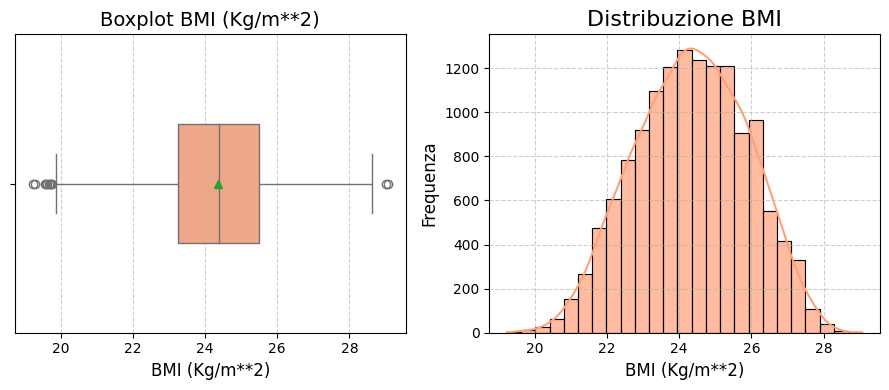

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset_cleaned, column_name='BMI', plot_color='lightsalmon', label='BMI (Kg/m**2)', hist_title="Distribuzione BMI")

In [ ]:
calories_dataset_cleaned["BMI"].describe()

,BMI
count,13877.000000
mean,24.348675
std,1.560408
min,19.227688
25%,23.243408
50%,24.382373
75%,25.494418
max,29.069767


I grafici per il BMI mostrano una distribuzione che tende a una forma campanulare.

L'istogramma indica che la maggior parte degli individui nel campione ha un BMI compreso tra 22 e 26, con un picco attorno ai 24.

Il boxplot conferma che la mediana del BMI è vicina a 24. Il 50% dei valori si concentra tra circa 23 e 25.

### Metabolismo Basale (BMR)

Successivamente, abbiamo introdotto il Metabolismo Basale (BMR), calcolato tramite la formula di Mifflin-St Jeor. Questa metrica stima le calorie che ogni persona brucia a riposo per sostenere le funzioni vitali. Fornire al modello questa "linea di base" metabolica è fondamentale. Permette infatti di isolare e comprendere meglio il consumo calorico aggiuntivo generato specificamente dall'attività fisica, andando oltre il dispendio energetico che l'individuo avrebbe comunque avuto.

Formula di Mifflin-St Jeor:


*   **Male**: BMR=(10×peso in kg)+(6.25×altezza in cm)−(5×età in anni)+5
*   **Female**: BMR=(10×peso in kg)+(6.25×altezza in cm)−(5×età in anni)−161



In [ ]:
def calculate_bmr(row):
    if row['Gender'] == 0: # Male
        return (10 * row['Weight']) + (6.25 * row['Height']) - (5 * row['Age']) + 5
    else: # Female
        return (10 * row['Weight']) + (6.25 * row['Height']) - (5 * row['Age']) - 161

In [ ]:
calories_dataset_cleaned['BMR'] = calories_dataset_cleaned.apply(calculate_bmr, axis=1)

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


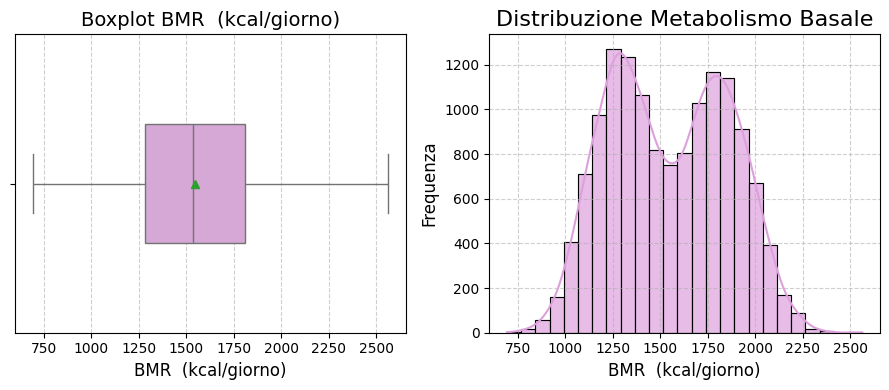

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset_cleaned, column_name='BMR', plot_color='plum', label='BMR  (kcal/giorno)', hist_title="Distribuzione Metabolismo Basale")

In [ ]:
calories_dataset_cleaned['BMR'].describe()

,BMR
count,13877.000000
mean,1547.198764
std,313.061414
min,692.750000
25%,1282.750000
50%,1535.250000
75%,1810.000000
max,2562.500000


I grafici per il metabolismo basale mostrano una distribuzione che tende ad essere campanulare e quasi simmetrica.

L'istogramma indica una concentrazione di valori BMR attorno alla media, che è di circa 1547 kcal/giorno, con una frequenza che diminuisce gradualmente allontanandosi dal picco.

Il boxplot conferma che la mediana del BMR si aggira attorno ai 1535 kcal/giorno. Il 50% degli individui presenta un BMR compreso tra 1282 e 1810 kcal/giorno.

Non si osservano outliner. Questo indica che i valori massimi e minimi rientrano entro i limiti considerati "normali" per la distribuzione dal metodo di visualizzazione.

La distribuzione del BMR è biologicamente plausibile e fornisce una stima del dispendio energetico a riposo, che potrebbe contribuire a migliorare la predizione del consumo calorico totale.

### Intensità Cardiaca

Infine, per contestualizzare meglio lo sforzo fisico, abbiamo calcolato l'intensità relativa dell'esercizio (HR_Ratio). La frequenza cardiaca assoluta può essere fuorviante, poiché uno stesso valore di battiti al minuto rappresenta uno sforzo molto diverso per persone di età differenti. Normalizzando la frequenza cardiaca di ogni individuo rispetto alla sua frequenza massima stimata (calcolata come 208-0.7*Età), otteniamo un indicatore di intensità molto più robusto e universale.

In [ ]:
FCMax = 208 - 0.7 * calories_dataset_cleaned['Age']
calories_dataset_cleaned['HR_Ratio'] = calories_dataset_cleaned['Heart_Rate'] / FCMax

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


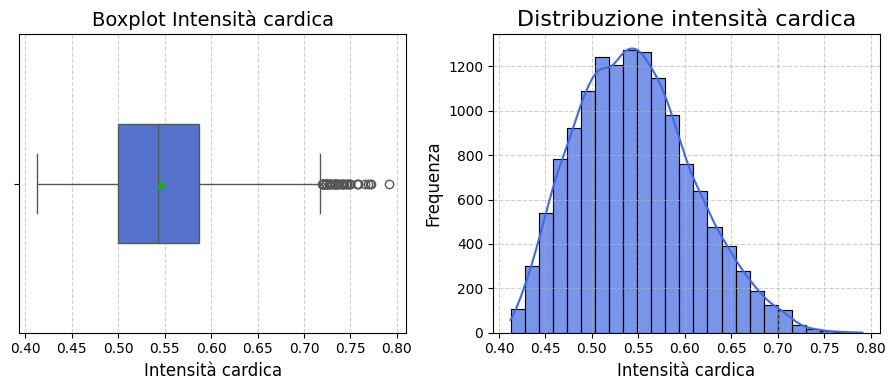

In [ ]:
plot_boxplot_and_histogram(dataframe=calories_dataset_cleaned, column_name='HR_Ratio', plot_color='royalblue',  label='Intensità cardica', hist_title="Distribuzione intensità cardica")

In [ ]:
calories_dataset_cleaned['HR_Ratio'].describe()

,HR_Ratio
count,13877.000000
mean,0.546225
std,0.062480
min,0.412371
25%,0.499457
50%,0.542677
75%,0.586907
max,0.790997


I grafici per l'intensità cardiaca mostrano una distribuzione che appare simmetrica e approssimativamente normale, concentrata attorno a un valore centrale.

L'istogramma indica che la maggior parte dei valori di HeartRatio si situa tra 0.50 e 0.60, con un picco attorno a 0.54-0.55. Questo riflette un'intensità di esercizio moderata per la maggior parte del campione rispetto alla loro frequenza cardiaca massima teorica.

Il boxplot conferma che la mediana dell'HeartRatio è di circa 0.54, molto vicina alla media. Il 50% dei valori si concentra tra 0.49 e 0.60.

Sono chiaramente presenti numerosi outlier nella parte alta della distribuzione. Questi potrebbero rappresentare sforzi massimali.
Questa variabile è particolarmente utile in quanto fornisce un'indicazione dell'intensità relativa dello sforzo, normalizzata per le caratteristiche individuali (età), che potrebbe essere un predittore più robusto del solo Heart_Rate assoluto per il consumo calorico.

### Matrice di correlazione

La nuova matrice di correlazione rivela l'impatto delle nuove feature sulle relazioni nel dataset.

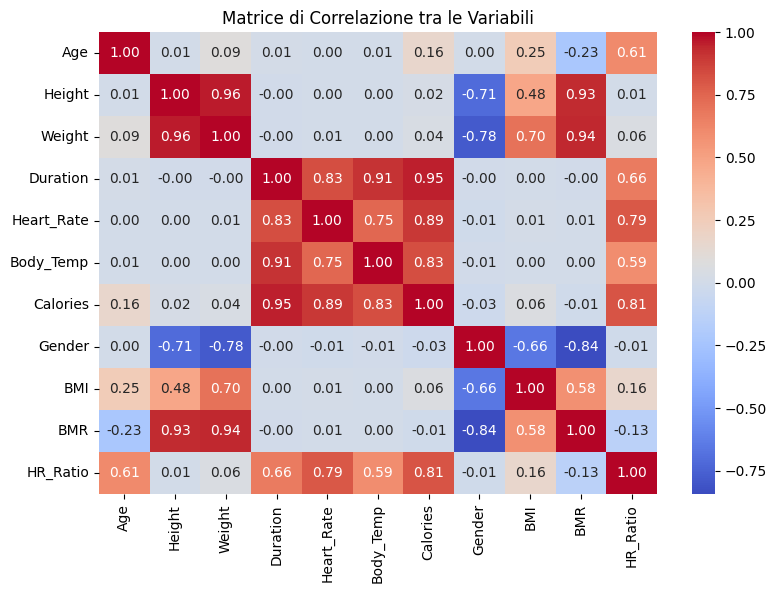

In [ ]:
plt.figure(figsize=(9, 6))
correlation_matrix = calories_dataset_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice di Correlazione tra le Variabili')
plt.show()

Analizzando le correlazioni delle nuove feature con la variabile target 'Calories':

*  HeartRatio (0.81): Questa feature come prevedibile emerge come un predittore forte e positivo per 'Calories'. Un valore di 0.81 indica che l'intensità relativa dello sforzo (rapporto tra frequenza cardiaca media e massima teorica) è un fattore altamente influente sul dispendio calorico.

*  BMI (0.06): Il Body Mass Index mostra una correlazione molto debole e positiva con 'Calories'. Questo suggerisce che il BMI ha un impatto lineare trascurabile sulle calorie bruciate durante l'allenamento, indicando che la massa corporea, da sola, non è un fattore determinante per il dispendio energetico in questo contesto.

*  BMR (-0.01): Il Metabolismo Basale presenta una correlazione estremamente debole e quasi nulla (o leggermente negativa) con 'Calories'.Indicando che il BMR non ha praticamente alcuna relazione lineare diretta con il consumo calorico in questo dataset, contrariamente a quanto si potrebbe ipotizzare a priori per il dispendio energetico durante l'attività.

Nonostante la bassa correlazione di BMI e BMR con il target, è importante considerare la multicollinearità derivante dalla creazione di queste feature.

*  HeartRatio e Heart_Rate: L'HeartRatio è derivato dalla Frequenza Cardiaca e dalla FCMax. Di conseguenza, ci si aspetta una correlazione molto alta tra HeartRatio e Heart_Rate. Per evitare ridondanze, si potrebbe considerare di includere solo HeartRatio nel modello.

* BMI e BMR con variabili anagrafiche originali (Weight, Height, Gender, Age): Essendo derivate da queste variabili, BMI e BMR presenteranno correlazioni con le loro componenti originali.

#### Calorie vs Intensità cardiaca

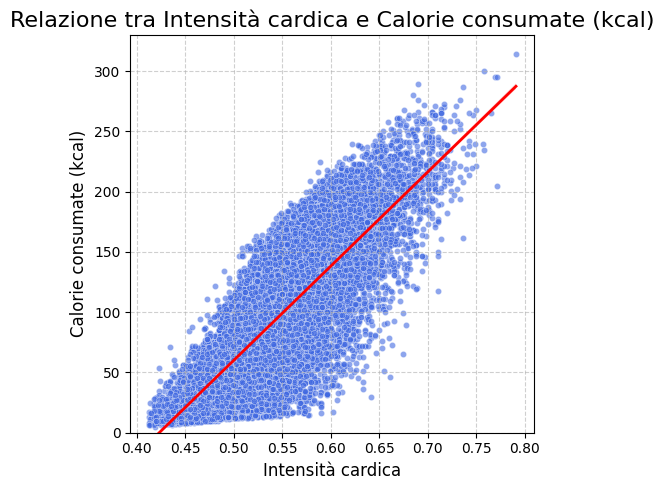

In [ ]:
plot_single_scatterplot(dataframe=calories_dataset_cleaned, x_column='HR_Ratio', y_column='Calories', plot_color='royalblue', xlabel='Intensità cardica', ylabel='Calorie consumate (kcal)')

Come confermato dalla matrice di correlazione il grafico tra intensità cardiaca e calorie consumate mostra una forte relazione lineare positiva.

Si può osservare una chiara tendenza: all'aumentare dell'HeartRatio (indicando un'intensità di allenamento relativa più elevata), il numero di calorie bruciate aumenta proporzionalmente. La retta di regressione si adatta bene alla nuvola di punti, confermando questa relazione.

Questa variabile, essendo una misura normalizzata dell'intensità dello sforzo, è particolarmente significativa e si conferma un predittore chiave nel modello per il consumo calorico, catturando l'efficienza e l'impegno relativo dell'individuo durante l'attività fisica.

## Definizione delle Variabili Predittive e Target

In [ ]:
y = calories_dataset_cleaned['Calories']
X = calories_dataset_cleaned.drop(columns=['Calories'])
print(f"Variabili predittive (X): {X.columns.tolist()}")
print(f"Variabile target (y): {y.name}")
print(f"Dimensione di X: {X.shape}")
print(f"Dimensione di y: {y.shape}")

Variabili predittive (X): ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Gender', 'BMI', 'BMR', 'HR_Ratio']
Variabile target (y): Calories
Dimensione di X: (13877, 10)
Dimensione di y: (13877,)


## Suddivisione del Dataset (Training e Test Set)

In [ ]:
X_train_comp, X_test_comp, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Selezione delle feature

La selezione delle feature è un passaggio cruciale per la costruzione di un modello predittivo robusto ed efficiente. Basandoci sulla matrice di correlazione generata in precedenza e sulle intuizioni derivate dall'analisi esplorativa, abbiamo optato per un sottoinsieme specifico di variabili predittive: 'Age', 'Duration', 'Body_Temp', 'BMI', e 'HR_Ratio'.

In [ ]:
selected_features = ['Age', 'Duration', 'Body_Temp', 'BMI', 'HR_Ratio']
X_train = X_train_comp[selected_features]
X_test = X_test_comp[selected_features]
X_train.head()

,Age,Duration,Body_Temp,BMI,HR_Ratio
10515,51,26.0,40.9,25.181077,0.562972
11024,48,19.0,40.3,26.880952,0.544725
1320,38,26.0,41.2,24.724520,0.562293
6472,67,29.0,41.2,25.099502,0.676598
2887,71,23.0,40.4,23.939481,0.694883



Le ragioni di questa scelta sono le seguenti:

* Correlazione con la variabile target: 'Duration', 'Body_Temp' e 'HR_Ratio' hanno mostrato i coefficienti di correlazione lineare più elevati con la variabile target 'Calories' (rispettivamente 0.96, 0.82 e 0.81). Questo indica che sono i predittori più influenti sul consumo calorico, il che è fisiologicamente atteso in un contesto di attività fisica.

* Priorità a 'HR_Ratio' su 'Heart_Rate': Nonostante 'Heart_Rate' presentasse un coefficiente di correlazione lineare leggermente superiore a 'HR_Ratio' con 'Calories' (0.90 vs 0.81), abbiamo scelto di includere 'HR_Ratio' e scartare 'Heart_Rate'. Questa decisione è motivata dalla logica fisiologica: la 'Frequenza Cardiaca Massima Teorica' (FCMax), calcolata in base all'età, varia significativamente tra gli individui. Pertanto, un valore assoluto di frequenza cardiaca ('Heart_Rate') può avere significati diversi per persone di età differenti. 'HR_Ratio', essendo un rapporto tra la frequenza cardiaca misurata e la FCMax, fornisce un'indicazione dell'intensità relativa dello sforzo, normalizzata per le caratteristiche individuali dell'età. Ci aspettiamo che questa misura normalizzata sia un predittore più robusto e generalizzabile dell'impegno fisico, e di conseguenza del dispendio calorico, rispetto al solo valore assoluto. Inoltre, l'inclusione di 'HR_Ratio' ci permette di evitare la multicollinearità derivante dalla forte correlazione tra 'Heart_Rate' e la nuova feature 'HR_Ratio'.

* Gestione della multicollinearità ('Height' e 'Weight'): Le variabili originali 'Height' e 'Weight' mostravano una correlazione lineare estremamente elevata tra loro (0.96), suggerendo un problema di multicollinearità. Abbiamo scelto di non includerle direttamente nel modello, preferendo invece la variabile derivata 'BMI' (Body Mass Index). Sebbene 'BMI' abbia mostrato una correlazione lineare debole con 'Calories' (0.06), cattura in modo combinato l'informazione di altezza e peso, offrendo un indicatore più contestualizzato della massa corporea e mitigando la ridondanza delle features originali.

* Esclusione di 'BMR': Il Metabolismo Basale ('BMR'), pur essendo una feature fisiologicamente rilevante per il consumo energetico a riposo, ha mostrato una correlazione lineare quasi nulla con 'Calories' (-0.01) nel contesto delle sessioni di allenamento di questo dataset. Pertanto, è stato escluso per non aggiungere complessità inutile al modello.

* Inclusione di 'Age' ed esclusione di 'Gender': 'Age' è stata mantenuta nonostante una correlazione lineare relativamente debole (0.15), in quanto l'età è un fattore biologico noto per influenzare il metabolismo e la capacità di esercizio. La variabile 'Gender' è stata esclusa dalle feature selezionate poiché la sua correlazione lineare con 'Calories' era trascurabile (-0.02 / 0.02) e le distribuzioni di calorie per genere non mostravano differenze significative.

# Addestramento e Valutazione dei Modelli di Predizione

Abbiamo deciso di adottare alcuni modelli di regressione per vedere come si comportano in relazione alla variabile da predire.

I modelli scelti sono stati :
- Regressione lineare,
- Regressione lineare con scalatura standard,
- Regressione lineare con scalatura minmax,
- Regressione lineare multivariata con discesa del gradiente,
- Regressione polinomiale
- Regressione Ridge,
- Rregressione Lasso,
- Regressione ElasticNet
- Regressione con alberi decisionali
- Random Forest
- XGBoost
- LightGBM
- CatBoost

In [ ]:
def calculate_metrics(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    rmspe = np.sqrt(np.mean((preds /y - 1) ** 2))
    return mse, mape, r2, rmspe

def add_model_evaluation(model, model_name, summary_df, X_train, y_train, X_test, y_test):
    mse_train, mape_train, r2_train, rmspe_train = calculate_metrics(X_train, y_train, model)
    mse_test, mape_test, r2_test, rmspe_test = calculate_metrics(X_test, y_test, model)

    new_row = pd.DataFrame(
        index=[model_name],
        columns=summary_df.columns
    )

    new_row.loc[model_name, ('Test Set', 'MSE')] = mse_test
    new_row.loc[model_name, ('Test Set', 'MAPE')] = mape_test
    new_row.loc[model_name, ('Test Set', 'R²')] = r2_test
    new_row.loc[model_name, ('Test Set', 'RMSPE')] = rmspe_train

    new_row.loc[model_name, ('Training Set', 'MSE')] = mse_train
    new_row.loc[model_name, ('Training Set', 'MAPE')] = mape_train
    new_row.loc[model_name, ('Training Set', 'R²')] = r2_train
    new_row.loc[model_name, ('Training Set', 'RMSPE')] = rmspe_test

    updated_df = pd.concat([summary_df, new_row])
    updated_df.sort_values(by=('Test Set', 'R²'), ascending=False, inplace=True)

    return updated_df

def plot_prediction_vs_true(y_true, y_pred, title, ax):
    ax.scatter(x=y_true, y=y_pred, alpha=0.6, label='Valori Predetti', s=15)
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    ax.plot(y_true, slope * y_true + intercept, color='red', linestyle='-', label='Retta di Regressione')
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, alpha=0.7, label='Perfetta Predizione (y=x)')
    ax.set_title(title)
    ax.set_xlabel('Valori Reali (kcal)')
    ax.set_ylabel('Valori Predetti (kcal)')
    ax.set_ylim(bottom=0)
    ax.legend()


In [ ]:
header = pd.MultiIndex.from_product(
    [['Training Set', 'Test Set'], ['MSE', 'MAPE', 'R²', 'RMSPE']],
    names=['Set', 'Metrica']
)
summary_df_multi = pd.DataFrame(columns=['Modello']).set_index('Modello')
summary_df_multi = pd.concat([summary_df_multi, pd.DataFrame(columns=header)], axis=1)


## Regressione Lineare

### Inizializzazione e addestramento del modello di Regressione Lineare

La Regressione Lineare è stata scelta come primo modello per stabilire una baseline di performance. Essendo il modello predittivo più semplice, assume che esista una relazione lineare tra le variabili di input (come Duration, Heart_Rate, ecc.) e la variabile target (Calories). Vengono addestrate tre varianti: una senza scalatura dei dati, una con StandardScaler e una con MinMaxScaler, per valutare l'impatto della normalizzazione delle feature sulle prestazioni del modello e sulla interpretabilità dei coefficienti.

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
model_lr_scaled = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])
model_lr_scaled.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('lin_reg', LinearRegression())])

In [ ]:
model_lr_minmax = Pipeline([
    ("standard_scaler", MinMaxScaler()),
    ("lin_reg", LinearRegression())
])
model_lr_minmax.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', MinMaxScaler()),
                ('lin_reg', LinearRegression())])

### Predizioni sul test set

In [ ]:
y_pred_lr = model_lr.predict(X_test)
y_pred_lr_scaled = model_lr_scaled.predict(X_test)
y_pred_lr_minmax = model_lr_minmax.predict(X_test)

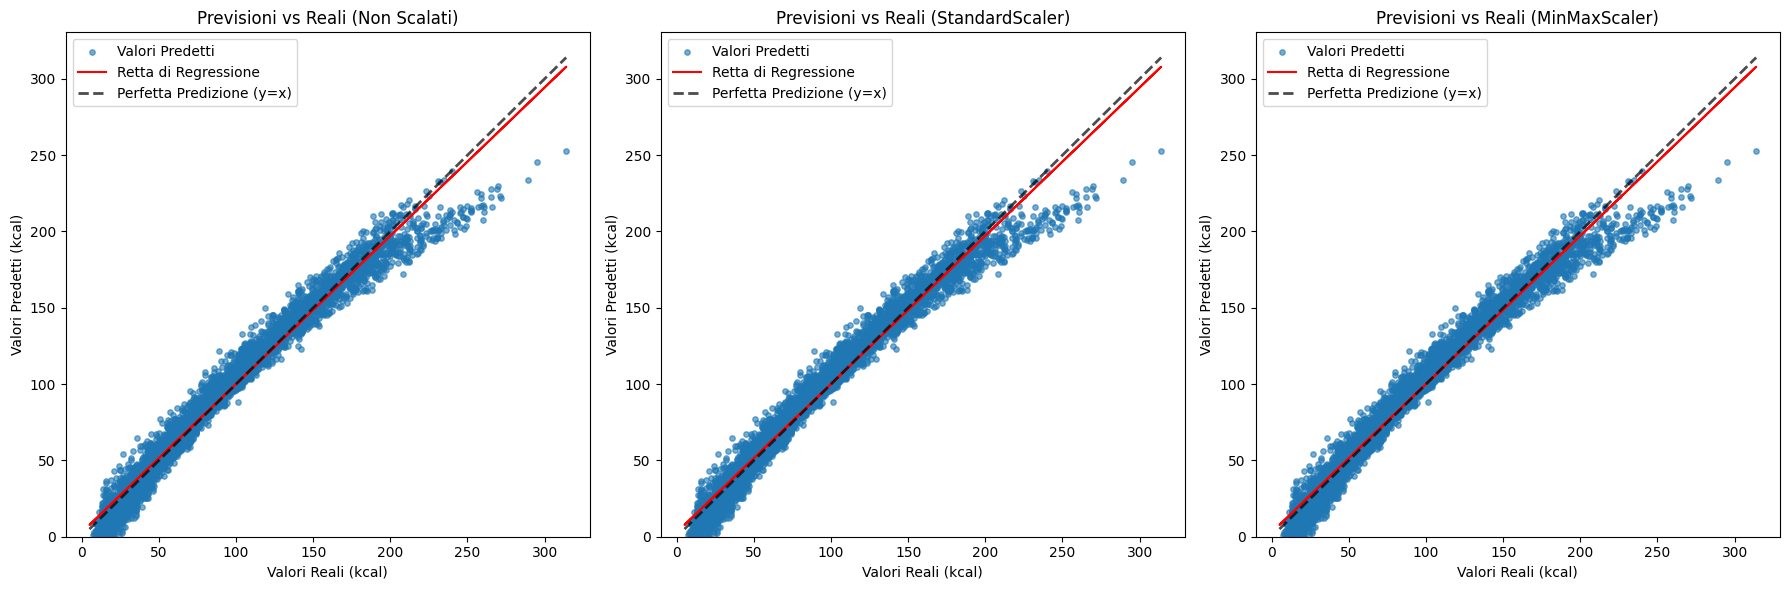

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_prediction_vs_true(y_test, y_pred_lr, 'Previsioni vs Reali (Non Scalati)', axes[0])
plot_prediction_vs_true(y_test, y_pred_lr_scaled, 'Previsioni vs Reali (StandardScaler)', axes[1])
plot_prediction_vs_true(y_test, y_pred_lr_minmax, 'Previsioni vs Reali (MinMaxScaler)', axes[2])
plt.tight_layout()
plt.show()

### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_lr, "RegressioneLineare", summary_df_multi, X_train, y_train, X_test, y_test)
summary_df_multi = add_model_evaluation(model_lr_scaled, "Scalato", summary_df_multi, X_train, y_train, X_test, y_test)
summary_df_multi = add_model_evaluation(model_lr_minmax, "MinMax", summary_df_multi, X_train, y_train, X_test, y_test)
summary_df_multi

Set                Training Set                                  Test Set  \
Metrica                     MSE      MAPE        R²     RMSPE         MSE   
RegressioneLineare   113.910154  0.154889  0.968973  0.320708  107.632734   
Scalato              113.910154  0.154889  0.968973  0.320708  107.632734   
MinMax               113.910154  0.154889  0.968973  0.320708  107.632734   

Set                                               
Metrica                 MAPE        R²     RMSPE  
RegressioneLineare  0.157076  0.969965  0.296684  
Scalato             0.157076  0.969965  0.296684  
MinMax              0.157076  0.969965  0.296684

La Regressione Lineare, in tutte le sue varianti di scalatura, si comporta molto bene con un R² estremamente elevato, indicando un'ottima capacità di catturare la relazione lineare principale nei dati. Gli errori assoluti (MSE, MAPE) indicano ancora un certo margine di miglioramento, ma per un modello così semplice, le performance sono notevoli.

### Analisi dei coefficienti del modello (interpretabilità)

In [ ]:
model_lr_coef = pd.Series(model_lr.coef_, index=X_train.columns)
model_lr_intercept = model_lr.intercept_
model_lr_scaled_coef = pd.Series(model_lr_scaled.named_steps["lin_reg"].coef_, index=X_train.columns)
model_lr_scaled_intercept = model_lr_scaled.named_steps["lin_reg"].intercept_
model_lr_minmax_coef = pd.Series(model_lr_minmax.named_steps["lin_reg"].coef_, index=X_train.columns)
model_lr_minmax_intercept = model_lr_minmax.named_steps["lin_reg"].intercept_
comparison_df = pd.DataFrame({
    'RegressioneLineare': model_lr_coef,
    'StandardScaler': model_lr_scaled_coef,
    'MinMaxScaler': model_lr_minmax_coef
})
intercept_row = pd.DataFrame({
    'RegressioneLineare': [model_lr_intercept],
    'StandardScaler': [model_lr_scaled_intercept],
    'MinMaxScaler': [model_lr_minmax_intercept]
}, index=['Intercetta'])
comparison_df = pd.concat([comparison_df, intercept_row])
comparison_df

,RegressioneLineare,StandardScaler,MinMaxScaler
Age,-0.375897,-6.390297,-22.177939
Duration,6.237119,48.635761,168.402217
Body_Temp,-14.372125,-9.052403,-50.302437
BMI,0.663046,1.035982,6.491061
HR_Ratio,413.771747,25.915001,148.469871
Intercetta,343.976760,96.336147,-7.594210


Sebbene per la regressione lineare semplice la scalatura non alteri le metriche di performance come l'R², essa è fondamentale per:

- Confrontare l'importanza delle feature: Analizzando la tabella dei coefficienti, si nota che nel modello non scalato i valori sono difficili da confrontare. Dopo aver applicato lo StandardScaler, i coefficienti diventano direttamente confrontabili: indicano la variazione nelle calorie per ogni aumento di una deviazione standard della feature corrispondente. Questo rende l'analisi di interpretabilità molto più robusta.


- Preparazione per modelli successivi: La normalizzazione dei dati è un pre-requisito essenziale per i modelli regolarizzati (come Ridge e Lasso) e per altri algoritmi sensibili alla scala delle feature.

## Regressione Lineare con Discesa del Gradiente

In [ ]:
def lr_gd_step(X1, y, theta, step_size):
    error = (X1 @ theta) - y
    grad = (2 / X1.shape[0]) * (X1.T @ error)
    new_theta = theta - step_size * grad
    return new_theta

### Scaling dei dati e aggiunta della colonna di bias

In [ ]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
X1_train_scaled = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X1_test_scaled = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

### Ciclo di training della Discesa del Gradiente

In [ ]:
iterations = 5_000
step_size = 0.01
tolerance = 1e-4
theta = np.zeros(X1_train_scaled.shape[1])
theta[0] = y_train_scaled.mean()
theta_vals = [theta.copy()]
current_iteration = 0
theta_prev = theta.copy()
converged = False
while not converged and current_iteration < iterations:
    theta = lr_gd_step(X1_train_scaled, y_train_scaled, theta, step_size)
    change_in_theta = np.linalg.norm(theta - theta_prev)
    if change_in_theta < tolerance:
        converged = True
    theta_vals.append(theta.copy())
    theta_prev = theta.copy()
    current_iteration += 1

### Calcolo dell'Errore Quadratico Medio (MSE) per ogni iterazione

In [ ]:
theta_matrix = np.array(theta_vals)
errors_by_step = X1_train_scaled @ theta_matrix.T - y_train_scaled[:, None]
mse_vals = np.mean(np.square(errors_by_step), axis=0)

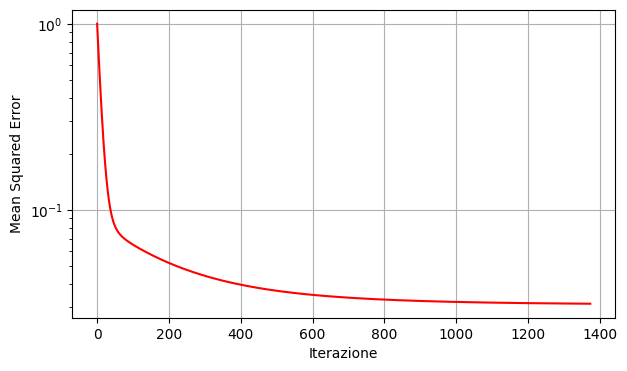

In [ ]:
plt.figure(figsize=(7, 4))
plt.semilogy(mse_vals, "r-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("Mean Squared Error");

### Analisi dei coefficienti

In [ ]:
pd.Series(theta, index=["Intercetta", *X_train.columns])

,0
Intercetta,-2.814414e-16
Age,-1.192833e-01
Duration,7.506005e-01
Body_Temp,-1.119316e-01
BMI,1.711407e-02
HR_Ratio,4.493454e-01


 L'analisi dei coefficienti standardizzati conferma che Duration e HR_Ratio sono i driver principali del consumo calorico, mentre Age e Body_Temp hanno un impatto minore (e potenzialmente più complesso da interpretare linearmente), e BMI un impatto quasi nullo.

## Regressione Polinomiale

Dopo aver visto le ottime performance della regressione lineare nel catturare la relazione principale nei dati, abbiamo voluto testare se fosse possibile migliorare ulteriormente l'adattamento del modello. Per questo, abbiamo introdotto la Regressione Polinomiale, che permette al modello di usare non solo le feature originali ma anche le loro potenze e le loro combinazioni. Per conferire al modello la flessibilità necessaria ad adattarsi a curve complesse, abbiamo scelto un grado polinomiale elevato (grado 10), combinato con una scalatura standard dei dati per migliorarne la stabilità.

### Inizializzazione e addestramento del modello di Regressione Polinomiale

In [ ]:
model_polynomial = Pipeline([
    ("poly", PolynomialFeatures(degree=10, include_bias=False)),
    ("scale", StandardScaler()),
    ("lin_reg", LinearRegression())
])
model_polynomial.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=10, include_bias=False)),
                ('scale', StandardScaler()), ('lin_reg', LinearRegression())])

### Predizione sul test set

In [ ]:
y_pred_polynomial = model_polynomial.predict(X_test)

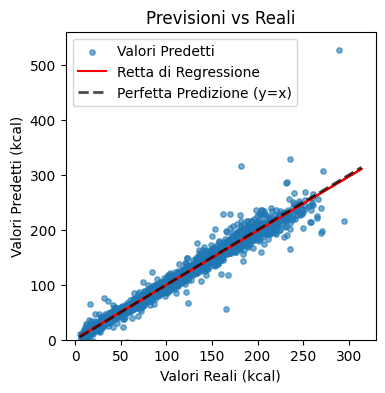

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_polynomial, 'Previsioni vs Reali', ax)
plt.show()

### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_polynomial, "Polinomiale", summary_df_multi, X_train, y_train, X_test, y_test)
summary_df_multi.loc['Polinomiale']

Set           Metrica
Training Set  MSE         23.262393
              MAPE         0.043265
              R²           0.993664
              RMSPE        0.140814
Test Set      MSE        138.703594
              MAPE         0.063935
              R²           0.961294
              RMSPE        0.067811
Name: Polinomiale, dtype: object

L'analisi delle metriche di performance per il modello di Regressione Polinomiale rivela un comportamento da interpretare con attenzione:

* MSE (Mean Squared Error): Si osserva un MSE molto basso sul training set (23.26), significativamente inferiore rispetto ai modelli lineari (113.9). Tuttavia, sul test set, l'MSE sale drasticamente a 138.70, superando anche l'MSE dei modelli lineari sul test set.

* MAPE (Mean Absolute Percentage Error): Il MAPE sul training set è estremamente basso (0.043), quasi perfetto. Ma sul test set, il MAPE aumenta a 0.064, indicando una performance percentuale peggiore sui dati non visti.

* R² (Coefficiente di Determinazione): L'R² sul training set è straordinariamente alto (0.993664), avvicinandosi a 1.0. Questo suggerisce che il modello si adatta quasi perfettamente ai dati di training. Tuttavia, l'R² sul test set scende a 0.961294. Sebbene un R² di 0.96 sia ancora un buon valore in assoluto, il calo significativo rispetto al training set e il confronto con i modelli lineari (che avevano R² di 0.969 sul test set) indicano un problema.

* RMSPE (Root Mean Squared Percentage Error): Anche l'RMSPE segue lo stesso andamento, molto basso sul training (0.14) e più alto sul test (0.068).

Questa marcata differenza tra le performance sul training set (quasi perfette) e quelle sul test set è un chiaro indicatore del fenomeno di **overfitting**. Il modello, avendo un grado polinomiale elevato, ha acquisito una complessità eccessiva. Invece di apprendere la relazione generale tra le variabili, ha "memorizzato" i dati di training, incluso il rumore di fondo, perdendo la capacità di generalizzare in modo affidabile su dati completamente nuovi.

### Analisi dei coefficienti

In [ ]:
polynomial_feature_names = model_polynomial.named_steps['poly'].get_feature_names_out(X_train.columns)
model_polynomial_coef = pd.Series(model_polynomial.named_steps['lin_reg'].coef_, index=polynomial_feature_names)
model_polynomial_intercept = model_polynomial.named_steps['lin_reg'].intercept_
model_polynomial_column_data = pd.concat([
    model_polynomial_coef,
    pd.Series([model_polynomial_intercept], index=['Intercetta'])
])
comparison_df['Polinomiale'] = model_polynomial_column_data
comparison_df['Polinomiale']

,Polinomiale
Age,6.815240e+07
Duration,-4.356155e+06
Body_Temp,-3.876847e+07
BMI,4.979053e+06
HR_Ratio,-9.970480e+07
Intercetta,9.633612e+01


I coefficienti variano enormemente in grandezza (da valori positivi nell'ordine di 10^7 per Age a negativi nell'ordine di 10^6 per Duration e HR_Ratio), e non presentano più un'interpretazione diretta e intuitiva come nel caso della regressione lineare semplice.

Questa estrema variabilità e l'elevata magnitudine dei coefficienti sono ulteriori indicatori della complessità eccessiva del modello e del fenomeno di **overfitting**. Il modello sta cercando di adattarsi a ogni minima variazione e rumore presente nel training set, assegnando pesi (coefficienti) molto grandi a termini polinomiali e di interazione. Questo lo rende estremamente sensibile a piccole variazioni nei dati di input, e ne compromette la stabilità e la capacità di generalizzazione su nuovi dati.

## Ridge

Dopo aver constatato che un modello polinomiale di grado elevato, pur adattandosi quasi perfettamente ai dati di training, rischia di cadere nel fenomeno dell'overfitting, il passo successivo è stato introdurre una tecnica di regolarizzazione. La Regressione Ridge affronta questo problema aggiungendo un termine di penalizzazione L2 alla funzione di errore. Questa penalizzazione è proporzionale alla somma dei quadrati dei coefficienti del modello e ha l'effetto di 'restringere' i coefficienti, smorzando le loro oscillazioni estreme e riducendone la grandezza. In questo modo, la Regressione Ridge ottiene un modello più semplice e robusto, che dovrebbe essere in grado di generalizzare meglio su dati completamente nuovi.

### Inizializzazione e addestramento del modello

In [ ]:
model_polynomial_ridge =  Pipeline([
    ("poly",   PolynomialFeatures(degree=10, include_bias=False)),
    ("scale",  StandardScaler()),
    ("ridge", Ridge(alpha=1))
])
model_polynomial_ridge.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=10, include_bias=False)),
                ('scale', StandardScaler()), ('ridge', Ridge(alpha=1))])

### Predizione sul test set

In [ ]:
y_pred_polynomial_ridge = model_polynomial_ridge.predict(X_test)

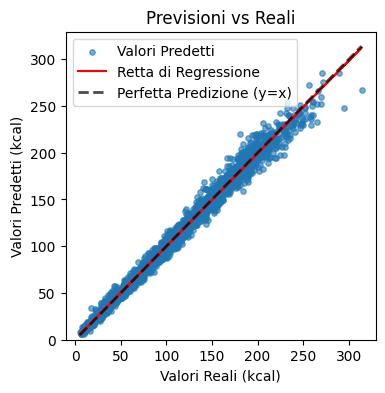

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_polynomial_ridge, 'Previsioni vs Reali', ax)
plt.show()

### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_polynomial_ridge, "Ridge", summary_df_multi, X_train, y_train, X_test, y_test)
summary_df_multi.loc[['Polinomiale', 'Ridge']]

Set         Training Set                                  Test Set            \
Metrica              MSE      MAPE        R²     RMSPE         MSE      MAPE   
Polinomiale    23.262393  0.043265  0.993664  0.140814  138.703594  0.063935   
Ridge          29.332158  0.046036   0.99201  0.070596   29.070005  0.045885   

Set                              
Metrica            R²     RMSPE  
Polinomiale  0.961294  0.067811  
Ridge        0.991888  0.069749

Il modello di Regressione Ridge dimostra un netto miglioramento nella capacità di generalizzazione rispetto al modello polinomiale non regolarizzato:

* MSE (Mean Squared Error): Si osserva un MSE molto simile tra il training set (29.33) e il test set (29.07). Questo è un risultato eccellente, significativamente inferiore rispetto all'MSE del modello polinomiale sul test set (138.70) e della regressione lineare standard (107.63). La vicinanza dei valori tra i due set indica una robusta capacità di generalizzazione.

* MAPE (Mean Absolute Percentage Error): Il MAPE è estremamente basso e quasi identico per training (0.046) e test set (0.045), indicando che, in media, l'errore percentuale è inferiore al 5%. Questo rappresenta una precisione molto elevata nelle predizioni.

* R² (Coefficiente di Determinazione): L'R² è altissimo su entrambi i set (0.99201 per il training e 0.991888 per il test). Questo significa che la Regressione Ridge, pur essendo un modello polinomiale, riesce a spiegare oltre il 99% della varianza nel consumo calorico. Il fatto che l'R² sul test set sia quasi identico a quello sul training set, e nettamente superiore a quello dei modelli precedenti, conferma che la regolarizzazione L2 ha mitigato efficacemente l'overfitting.

* RMSPE (Root Mean Squared Percentage Error): Anche l'RMSPE è molto basso e coerente tra training (0.070) e test (0.069), rafforzando ulteriormente la fiducia nella precisione relativa del modello.

Il risultato finale è un modello che, pur mantenendo un'alta capacità predittiva (grazie alle feature polinomiali), è molto più robusto e ha maggiori probabilità di funzionare bene anche su dati completamente nuovi, raggiungendo così un equilibrio migliore tra complessità e capacità di generalizzazione.

### Analisi dei coefficienti

In [ ]:
polynomial_ridge_feature_names = model_polynomial_ridge.named_steps['poly'].get_feature_names_out(X_train.columns)
model_polynomial_ridge_coef = pd.Series(model_polynomial_ridge.named_steps['ridge'].coef_, index=polynomial_ridge_feature_names)
model_polynomial_ridge_intercept = model_polynomial_ridge.named_steps['ridge'].intercept_
model_polynomial_ridge_column_data = pd.concat([
    model_polynomial_ridge_coef,
    pd.Series([model_polynomial_ridge_intercept], index=['Intercetta'])
])
comparison_df['Ridge'] = model_polynomial_ridge_column_data
comparison_df[['Polinomiale', 'Ridge']]

,Polinomiale,Ridge
Age,6.815240e+07,-0.003522
Duration,-4.356155e+06,5.164683
Body_Temp,-3.876847e+07,-0.019537
BMI,4.979053e+06,4.257136
HR_Ratio,-9.970480e+07,1.976997
Intercetta,9.633612e+01,96.336147


Nel modello polinomiale non regolarizzato, avevamo osservato coefficienti con valori assoluti estremamente elevati.
Con la Regressione Ridge, i coefficienti sono stati drasticamente ridotti.
Questa 'compressione' dei coefficienti è l'effetto diretto della regolarizzazione L2, che penalizza i modelli con coefficienti di valore elevato, riducendo la complessità del modello e la sua sensibilità alle piccole fluttuazioni nei dati.

# Lasso

Per il modello di Regressione LASSO, si esplora un'altra tecnica di regolarizzazione, l'L1, che si differenzia dalla Ridge (L2) per la sua capacità di effettuare una selezione delle feature. Infatti la Regressione LASSO aggiunge un termine di penalizzazione proporzionale alla somma dei valori assoluti dei coefficienti del modello. Questo parametro, controllato da alpha, non solo riduce la magnitudine dei coefficienti (come fa Ridge) ma può anche azzerare completamente i coefficienti delle feature meno importanti.

### Inizializzazione e addestramento del modello

In [ ]:
model_polynomial_lasso =  Pipeline([
    ("poly",   PolynomialFeatures(degree=10, include_bias=False)),
    ("scale",  StandardScaler()),
    ("lasso", Lasso(alpha=0.05, max_iter=10000))
])
model_polynomial_lasso.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=10, include_bias=False)),
                ('scale', StandardScaler()),
                ('lasso', Lasso(alpha=0.05, max_iter=10000))])

### Predizione sul test set

In [ ]:
y_pred_polynomial_lasso = model_polynomial_lasso.predict(X_test)

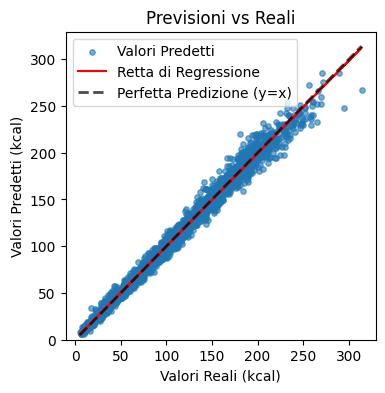

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_polynomial_ridge, 'Previsioni vs Reali', ax)
plt.show()

### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_polynomial_lasso, "Lasso", summary_df_multi, X_train, y_train, X_test, y_test)
summary_df_multi.loc[['Polinomiale', 'Ridge', 'Lasso']]

Set         Training Set                                  Test Set            \
Metrica              MSE      MAPE        R²     RMSPE         MSE      MAPE   
Polinomiale    23.262393  0.043265  0.993664  0.140814  138.703594  0.063935   
Ridge          29.332158  0.046036   0.99201  0.070596   29.070005  0.045885   
Lasso          32.782952  0.053176   0.99107  0.084825   31.777228  0.053809   

Set                              
Metrica            R²     RMSPE  
Polinomiale  0.961294  0.067811  
Ridge        0.991888  0.069749  
Lasso        0.991132  0.081624

Il modello di Regressione LASSO mostra risultati ancora molto solidi e paragonabili a quelli ottenuti con la Regressione Ridge, confermando l'efficacia della regolarizzazione nel combattere l'overfitting:

* MSE (Mean Squared Error): Il valore di MSE si mantiene basso e molto vicino tra il training set (32.782) e il test set (31.777). Questi valori sono leggermente superiori a quelli della Regressione Ridge (circa 29), ma restano notevolmente inferiori rispetto al modello polinomiale non regolarizzato (138.70 sul test set).

* MAPE (Mean Absolute Percentage Error): Il MAPE è anch'esso molto basso e coerente tra training (0.053) e test set (0.053), con valori comparabili a quelli di Ridge. Ciò suggerisce che, in media, le predizioni di LASSO si discostano di circa il 5% dai valori reali.

* R² (Coefficiente di Determinazione): L'R² è molto alto e simile per training (0.991) e test set (0.991). Questo indica che il modello LASSO spiega oltre il 99% della varianza nel consumo calorico. Anche qui, l'R² sul test set è quasi identico a quello sul training set, confermando l'assenza di overfitting e un'ottima generalizzazione. Sebbene leggermente inferiore a Ridge, il valore rimane eccellente.

* RMSPE (Root Mean Squared Percentage Error): L'RMSPE è basso e costante tra training (0.082) e test (0.082), rafforzando l'affidabilità delle previsioni percentuali del modello.

In sintesi, la Regressione LASSO si dimostra un modello robusto ed efficace, capace di ottenere performance predittive paragonabili a quelle di Ridge e di generalizzare molto bene su dati non visti.

### Analisi dei coefficenti

In [ ]:
polynomial_lasso_feature_names = model_polynomial_lasso.named_steps['poly'].get_feature_names_out(X_train.columns)
model_polynomial_lasso_coef = pd.Series(model_polynomial_lasso.named_steps['lasso'].coef_, index=polynomial_lasso_feature_names)
model_polynomial_lasso_intercept = model_polynomial_lasso.named_steps['lasso'].intercept_
model_polynomial_lasso_column_data = pd.concat([
    model_polynomial_lasso_coef,
    pd.Series([model_polynomial_lasso_intercept], index=['Intercetta'])
])
comparison_df['Lasso'] = model_polynomial_lasso_column_data
comparison_df[['Polinomiale', 'Ridge', 'Lasso']]

,Polinomiale,Ridge,Lasso
Age,6.815240e+07,-0.003522,-0.000000
Duration,-4.356155e+06,5.164683,0.000000
Body_Temp,-3.876847e+07,-0.019537,0.000000
BMI,4.979053e+06,4.257136,-1.909497
HR_Ratio,-9.970480e+07,1.976997,0.851193
Intercetta,9.633612e+01,96.336147,96.336147


L'analisi dei coefficienti del modello LASSO mette in luce la caratteristica fondamentale di questa tecnica di regolarizzazione: la sua capacità di effettuare una 'selezione automatica delle feature'.

Mentre la Regressione Lineare senza regolarizzazione mostrava coefficienti estremi e instabili, e la Regressione Ridge li riduceva ma li manteneva tutti, LASSO agisce in modo più selettivo. Nel nostro caso, osserviamo che le variabili 'Age', 'Duration' e 'Body_Temp' hanno visto i loro coefficienti azzerati. Questo significa che, nello spazio di feature polinomiali che abbiamo creato, il modello LASSO ha implicitamente deciso che queste variabili (o i termini polinomiali e di interazione ad esse associati) non erano strettamente necessarie per la predizione, data la presenza delle altre feature.

Al contrario, 'BMI' e soprattutto 'HR_Ratio' mantengono coefficienti significativi e diversi da zero. Questo ci indica che LASSO ha 'selezionato' queste due variabili come le più cruciali per prevedere il consumo calorico, anche in un contesto così complesso di interazioni polinomiali. Il coefficiente di 'HR_Ratio' si conferma positivo e influente, ribadendo la sua importanza come indicatore dell'intensità dello sforzo.

# Elastic Net

Elastic Net è un potente modello di regressione regolarizzato che combina le penalità di due dei più noti modelli di regolarizzazione: la penalità L1 di LASSO e la penalità L2 di Ridge. Il parametro l1_ratio (compreso tra 0 e 1) controlla il bilanciamento tra queste due penalità: un valore di l1_ratio pari a 0 corrisponde a Ridge, mentre un valore di 1 corrisponde a LASSO. Abbiamo inizializzato il modello con l1_ratio=0.2 (che significa che viene applicata una penalità composta per l'80% da Ridge e per il 20% da LASSO). Questa scelta è stata dettata dal fatto che avevamo ottenuto risultati migliori precedentemente con Ridge rispetto a LASSO, suggerendo che una maggiore enfasi sulla penalità L2 potesse essere vantaggiosa per il nostro dataset.

### Inizializzazione e allenamento del modello

In [ ]:
model_polynomial_elastic_net =  Pipeline([
    ("poly",   PolynomialFeatures(degree=10, include_bias=False)),
    ("scale",  StandardScaler()),
    ("el_net", ElasticNet(alpha=0.5, l1_ratio=0.2, max_iter=1000))
])
model_polynomial_elastic_net.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.791e+04, tolerance: 3.566e+03
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly', PolynomialFeatures(degree=10, include_bias=False)),
                ('scale', StandardScaler()),
                ('el_net', ElasticNet(alpha=0.5, l1_ratio=0.2))])

### Predizione sul test set

In [ ]:
y_pred_polynomial_elastic_net = model_polynomial_elastic_net.predict(X_test)

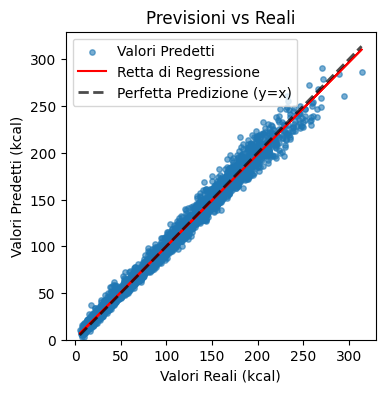

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_polynomial_elastic_net, 'Previsioni vs Reali', ax)
plt.show()

### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_polynomial_elastic_net, "Elastic Net", summary_df_multi, X_train, y_train, X_test, y_test)
summary_df_multi.loc[['Polinomiale', 'Ridge', 'Lasso', 'Elastic Net']]

Set         Training Set                                  Test Set            \
Metrica              MSE      MAPE        R²     RMSPE         MSE      MAPE   
Polinomiale    23.262393  0.043265  0.993664  0.140814  138.703594  0.063935   
Ridge          29.332158  0.046036   0.99201  0.070596   29.070005  0.045885   
Lasso          32.782952  0.053176   0.99107  0.084825   31.777228  0.053809   
Elastic Net     39.41758  0.065292  0.989263  0.109258   38.332369  0.065893   

Set                              
Metrica            R²     RMSPE  
Polinomiale  0.961294  0.067811  
Ridge        0.991888  0.069749  
Lasso        0.991132  0.081624  
Elastic Net  0.989303  0.104815

Il modello Elastic Net mostra risultati competitivi, sebbene leggermente inferiori rispetto ai precedenti modelli:

* MSE (Mean Squared Error): I valori di MSE sono vicini tra il training set (39.417) e il test set (38.332), indicando una solida capacità di generalizzazione. Questi valori sono superiori a quelli della Regressione Ridge (circa 29) e LASSO (circa 32), suggerendo che la combinazione specifica di penalità L1/L2 non ha superato le performance del solo Ridge per questo problema, ma si mantiene ben distante dall'overfitting del modello polinomiale non regolarizzato (138.70 sul test set).

* MAPE (Mean Absolute Percentage Error): Il MAPE è basso e coerente tra training (0.065) e test set (0.066), indicando un errore percentuale medio gestibile, anche se leggermente superiore rispetto a Ridge e LASSO.

* R² (Coefficiente di Determinazione): L'R² è molto alto e simile per training (0.989263) e test set (0.989303). Questo significa che il modello Elastic Net spiega quasi il 99% della varianza nel consumo calorico. La coerenza tra i due set conferma l'efficacia della regolarizzazione nel prevenire l'overfitting.

* RMSPE (Root Mean Squared Percentage Error): Anche l'RMSPE è basso e costante tra training (0.109) e test (0.104), sebbene anch'esso leggermente più alto rispetto a Ridge e LASSO.

In sintesi, Elastic Net si conferma un modello robusto e performante, capace di generalizzare efficacemente. Anche se le sue metriche assolute (MSE, MAPE, RMSPE) sono marginalmente peggiori rispetto a quelle ottenute con la sola Ridge Regression.

### Valutazione dei coefficienti

In [ ]:
polynomial_elastic_net_feature_names = model_polynomial_elastic_net.named_steps['poly'].get_feature_names_out(X_train.columns)
model_polynomial_elastic_net_coef = pd.Series(model_polynomial_elastic_net.named_steps['el_net'].coef_, index=polynomial_elastic_net_feature_names)
model_polynomial_elastic_net_intercept = model_polynomial_elastic_net.named_steps['el_net'].intercept_
model_polynomial_elastic_net_column_data = pd.concat([
    model_polynomial_elastic_net_coef,
    pd.Series([model_polynomial_elastic_net_intercept], index=['Intercetta'])
])
comparison_df['ElasticNet'] = model_polynomial_elastic_net_column_data

In [ ]:
comparison_df[['Polinomiale', 'Ridge', 'Lasso', 'ElasticNet']]

,Polinomiale,Ridge,Lasso,ElasticNet
Age,6.815240e+07,-0.003522,-0.000000,-0.101529
Duration,-4.356155e+06,5.164683,0.000000,0.734769
Body_Temp,-3.876847e+07,-0.019537,0.000000,0.082840
BMI,4.979053e+06,4.257136,-1.909497,-0.392138
HR_Ratio,-9.970480e+07,1.976997,0.851193,0.536340
Intercetta,9.633612e+01,96.336147,96.336147,96.336147


I coefficienti del modello Elastic Net ci mostrano un bilanciamento interessante tra l'approccio di Ridge e quello di LASSO. Con la nostra configurazione che privilegia la penalità L2 (quella di Ridge), i coefficienti delle feature non vengono azzerati, ma vengono ridotti e stabilizzati. Vediamo quindi che tutte le variabili mantengono un certo 'peso' nel modello, ma in modo più controllato rispetto al modello polinomiale senza regolarizzazione. In particolare, le feature 'BMI' e 'HR_Ratio' si confermano con coefficienti significativi.

## Analisi e valutazione modelli eseguiti fino ad ora

In [ ]:
comparison_df

,RegressioneLineare,StandardScaler,MinMaxScaler,Polinomiale,Ridge,Lasso,ElasticNet
Age,-0.375897,-6.390297,-22.177939,6.815240e+07,-0.003522,-0.000000,-0.101529
Duration,6.237119,48.635761,168.402217,-4.356155e+06,5.164683,0.000000,0.734769
Body_Temp,-14.372125,-9.052403,-50.302437,-3.876847e+07,-0.019537,0.000000,0.082840
BMI,0.663046,1.035982,6.491061,4.979053e+06,4.257136,-1.909497,-0.392138
HR_Ratio,413.771747,25.915001,148.469871,-9.970480e+07,1.976997,0.851193,0.536340
Intercetta,343.976760,96.336147,-7.594210,9.633612e+01,96.336147,96.336147,96.336147


L'analisi comparativa dei coefficienti dei modelli offre una chiara visione dell'evoluzione e della natura di ciascun approccio, mostrando come la complessità del modello e l'applicazione della regolarizzazione influenzino i pesi assegnati a ciascuna feature.

* La Regressione Lineare (base e scalata) mostra l'impatto della scalatura: i coefficienti del modello non scalato sono direttamente interpretabili sulla scala originale delle feature (es. Duration con 6.237), mentre quelli dei modelli scalati, pur avendo grandezze diverse, indicano l'importanza relativa delle feature dopo la normalizzazione (es. Duration e HR_Ratio rimangono i più influenti). Il coefficiente negativo e fisiologicamente illogico per Body_Temp nel modello non scalato suggerisce la presenza di problematiche legate alle correlazioni o alla natura dei dati.

* Il modello Polinomiale non regolarizzato si distingue per i suoi coefficienti estremamente elevati e volatili. Questo è il segnale più evidente di overfitting: il modello ha adattato eccessivamente i suoi parametri al rumore presente nei dati di training, rendendolo instabile e con scarsa capacità di generalizzazione.

L'introduzione della regolarizzazione ha trasformato radicalmente il comportamento dei coefficienti:

* La Regressione Ridge ha drasticamente ridotto la magnitudine di tutti i coefficienti, spingendoli verso lo zero. Non azzera alcun coefficiente, ma distribuisce il 'peso' tra tutte le feature, stabilizzando il modello e migliorando la sua capacità di generalizzazione.

* La Regressione LASSO ha dimostrato la sua capacità di selezione delle feature. Ha azzerato i coefficienti di 'Age', 'Duration' e 'Body_Temp' (nello spazio polinomiale). Questo indica che il modello si affida principalmente a 'BMI' (-1.909) e 'HR_Ratio' (0.851) per le sue predizioni, creando un modello più 'sparso', semplice e interpretabile.

* Elastic Net offre un compromesso tra i due. Con un l1_ratio di 0.2 (privilegiando la penalità L2), i suoi coefficienti sono ridotti e stabili, simili a Ridge, ma con valori che mostrano una leggera tendenza verso l'azzeramento rispetto a Ridge (pur non raggiungendolo per nessuna delle feature principali mostrate in tabella, diversamente da Lasso). Questo approccio ibrido consente di bilanciare la stabilizzazione dei coefficienti con una potenziale selezione.

In conclusione, l'evoluzione dei coefficienti dimostra il passaggio da modelli instabili a soluzioni robuste e generalizzabili grazie alla regolarizzazione. Duration e HR_Ratio (o solo HR_Ratio e BMI nel caso di LASSO) emergono costantemente come i predittori più critici per il consumo calorico, mentre la scelta della regolarizzazione determina come le altre variabili contribuiscono al modello finale.

In [ ]:
summary_df_multi.sort_values(by=('Test Set', 'R²'), ascending=False)

Set                Training Set                                  Test Set  \
Metrica                     MSE      MAPE        R²     RMSPE         MSE   
Ridge                 29.332158  0.046036   0.99201  0.070596   29.070005   
Lasso                 32.782952  0.053176   0.99107  0.084825   31.777228   
Elastic Net            39.41758  0.065292  0.989263  0.109258   38.332369   
RegressioneLineare   113.910154  0.154889  0.968973  0.320708  107.632734   
Scalato              113.910154  0.154889  0.968973  0.320708  107.632734   
MinMax               113.910154  0.154889  0.968973  0.320708  107.632734   
Polinomiale           23.262393  0.043265  0.993664  0.140814  138.703594   

Set                                               
Metrica                 MAPE        R²     RMSPE  
Ridge               0.045885  0.991888  0.069749  
Lasso               0.053809  0.991132  0.081624  
Elastic Net         0.065893  0.989303  0.104815  
RegressioneLineare  0.157076  0.969965  0.296684  
Scalato             0.157076  0.969965  0.296684  
MinMax              0.157076  0.969965  0.296684  
Polinomiale         0.063935  0.961294  0.067811

Da questo riassunto delle performance ordinate, si può chiaramente osservare che i modelli regolarizzati (Ridge, Lasso ed Elastic Net) hanno prodotto i risultati nettamente migliori sul test set. Questo dimostra la loro superiore capacità di generalizzazione e la loro efficacia nel mitigare l'overfitting.

## Regressione con alberi decisionali

Dopo aver addestrato diversi modelli di regressione lineare e polinomiale, abbiamo deciso di affrontare modelli più sofisticati in grado di catturare nel migliore dei modi le relazioni non lineari tra le feature. Gli Alberi di Regressione (Decision Tree Regressor) sono noti per la loro capacità di creare confini di decisione complessi e di catturare interazioni non lineari. Vengono esplorate due configurazioni principali per comprendere l'impatto degli iperparametri di potatura sulla performance e sulla complessità del modello.

### Inizializzazione e allenamento del modello

Il primo albero di regressione è stato addestrato con un iperparametro max_depth=3, limitando significativamente la sua profondità e complessità.

In [ ]:
model_tree_regression = DecisionTreeRegressor(max_depth=3, min_samples_split=2000, random_state=42)
model_tree_regression.fit(X_train_comp, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=2000, random_state=42)

Questo forza l'albero a rimanere molto semplice, risultando in un albero con un numero limitato di foglie (7 foglie come mostrato da get_n_leaves()).

In [ ]:
model_tree_regression.get_n_leaves()

np.int64(7)

La visualizzazione dell'albero conferma la sua struttura compatta e facilmente interpretabile.

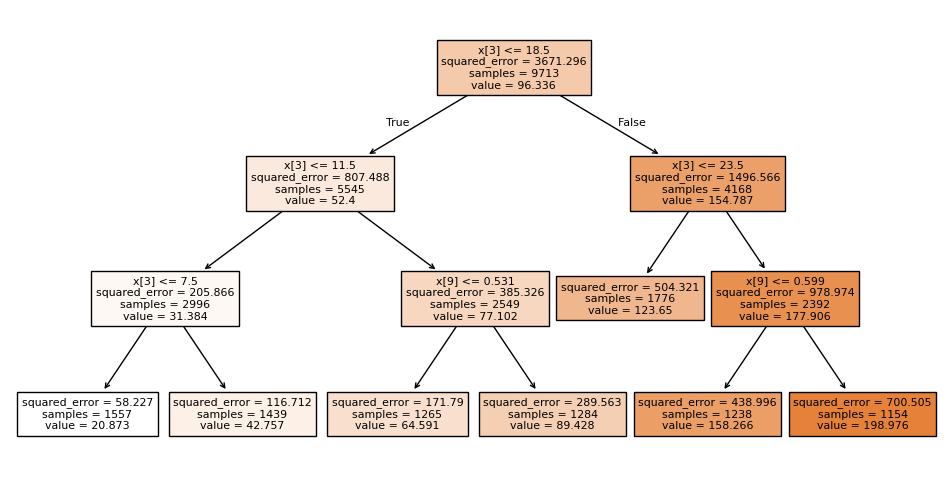

In [ ]:
plt.figure(figsize=(12, 6))
plot_tree(model_tree_regression, filled=True);

### Predizione sul test set

In [ ]:
y_pred_tree_regression = model_tree_regression.predict(X_test_comp)

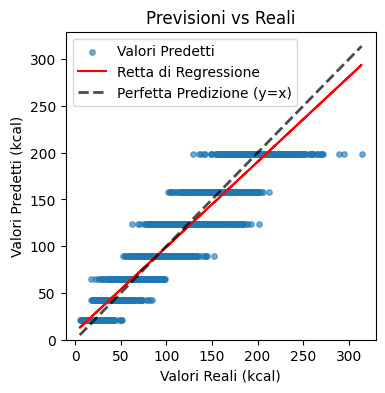

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_tree_regression, 'Previsioni vs Reali', ax)
plt.show()

### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_tree_regression, "Regression Tree", summary_df_multi, X_train_comp, y_train, X_test_comp, y_test)
summary_df_multi.loc['Regression Tree']

Set           Metrica
Training Set  MSE        318.671273
              MAPE         0.191263
              R²           0.913199
              RMSPE        0.309686
Test Set      MSE        327.491264
              MAPE         0.200231
              R²           0.908612
              RMSPE        0.290344
Name: Regression Tree, dtype: object

Il modello rivela quanto segue:

* MSE (Mean Squared Error): I valori di MSE sono alti sia sul training set (318.67) che sul test set (327.49). Questi valori sono considerevolmente superiori a quelli ottenuti con i modelli precedenti.

* MAPE (Mean Absolute Percentage Error): Il MAPE è anch'esso alto (0.19 sul training, 0.20 sul test), suggerendo che le predizioni, in media, si discostano di circa il 20% dai valori reali.

* R² (Coefficiente di Determinazione): L'R² è relativamente basso, circa 0.913 sul training set e 0.908 sul test set. Sebbene un R² del 90% sia spesso considerato buono, in confronto ai modelli precedenti che raggiungevano quasi il 99%, questo valore indica una capacità predittiva significativamente inferiore. La vicinanza tra i valori di training e test suggerisce che il modello non sta soffrendo di overfitting, ma piuttosto di underfitting.

* RMSPE (Root Mean Squared Percentage Error): L'RMSPE è anch'esso elevato (0.309 sul training, 0.290 sul test).

Come possiamo vedere con una profondità massima così piccola l'accuratezza del nostro modello non è delle migliori. I risultati indicano che l'albero è troppo semplice per catturare la complessità della relazione tra le feature e il consumo calorico, risultando in un **underfitting**.

### Importanza delle Feature

In [ ]:
pd.Series(model_tree_regression.feature_importances_, index=X_train_comp.columns).sort_values(ascending=False)

,0
Duration,0.957532
HR_Ratio,0.042468
Height,0.000000
Age,0.000000
Heart_Rate,0.000000
Weight,0.000000
Body_Temp,0.000000
Gender,0.000000
BMI,0.000000
BMR,0.000000


### Inizializzazione e allenamento del modello

Il secondo albero di regressione è stato addestrato rimuovendo il limite esplicito sulla max_depth.

In [ ]:
model_tree_regression_h = DecisionTreeRegressor(max_depth=None, min_samples_split=500, random_state=42)
model_tree_regression_h.fit(X_train_comp, y_train)

DecisionTreeRegressor(min_samples_split=500, random_state=42)

Questa configurazione permette all'albero di crescere molto più in profondità e di creare un numero maggiore di nodi foglia (30 foglie come indicato da get_n_leaves()).

In [ ]:
model_tree_regression_h.get_n_leaves()

np.int64(30)

Infatti la visualizzazione dell'albero conferma una struttura molto più grande e complessa rispetto al modello precedente. Questo aumenta la sua capacità di adattamento ai dati di training.

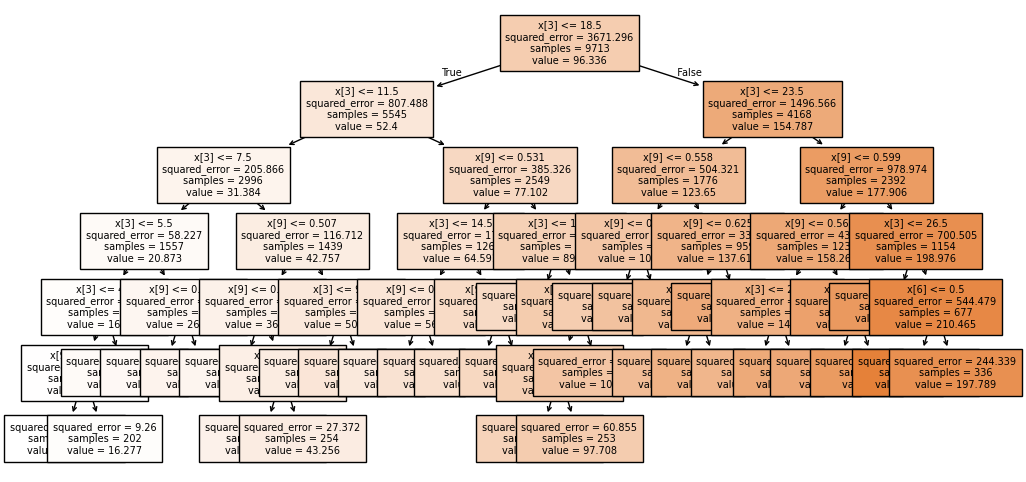

In [ ]:
plt.figure(figsize=(12, 6))
plot_tree(model_tree_regression_h, filled=True, fontsize=7);

### Predizione sul test set

In [ ]:
y_pred_tree_regression_h = model_tree_regression_h.predict(X_test_comp)

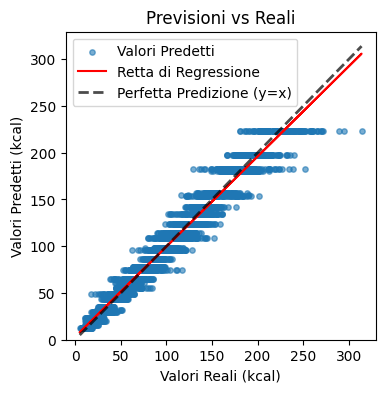

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_tree_regression_h, 'Previsioni vs Reali', ax)
plt.show()

### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_tree_regression_h, "Regression Tree H", summary_df_multi, X_train_comp, y_train, X_test_comp, y_test)
summary_df_multi.loc[['Regression Tree', 'Regression Tree H']]

Set               Training Set                                  Test Set  \
Metrica                    MSE      MAPE        R²     RMSPE         MSE   
Regression Tree     318.671273  0.191263  0.913199  0.309686  327.491264   
Regression Tree H   128.312208  0.102145   0.96505  0.155273  124.015053   

Set                                              
Metrica                MAPE        R²     RMSPE  
Regression Tree    0.200231  0.908612  0.290344  
Regression Tree H  0.105521  0.965393  0.147707

Il secondo modello (Regression Tree H) mostra un netto miglioramento rispetto al precedente albero più semplice:

* MSE (Mean Squared Error): L'MSE sul training set è drasticamente diminuito a 128.31, e sul test set a 124.01. Questi valori sono ancora superiori a quelli dei modelli di precedenti, ma sono significativamente migliori rispetto al precedente Regression Tree.

* MAPE (Mean Absolute Percentage Error): Il MAPE si riduce a 0.102 sul training e 0.105 sul test, indicando un errore percentuale medio di circa il 10%.

* R² (Coefficiente di Determinazione): L'R² è notevolmente migliorato, raggiungendo circa 0.965 sul training set e 0.965 sul test set. Questo valore è molto più competitivo.

* RMSPE (Root Mean Squared Percentage Error): Anche l'RMSPE è migliorato (0.155 sul training, 0.147 sul test).

Questo miglioramento delle metriche indica che permettere all'albero di crescere maggiormente ha aumentato la sua capacità di catturare le relazioni nei dati, riducendo l'underfitting. Sebbene non abbia raggiunto le performance dei migliori modelli regolarizzati, dimostra la flessibilità degli alberi decisionali nel migliorare l'accuratezza con una complessità maggiore.

### Importanza delle Feature

In [ ]:
pd.Series(model_tree_regression_h.feature_importances_, index=X_train_comp.columns).sort_values(ascending=False)

,0
Duration,0.928545
HR_Ratio,0.068340
Gender,0.003115
Age,0.000000
Height,0.000000
Weight,0.000000
Body_Temp,0.000000
Heart_Rate,0.000000
BMI,0.000000
BMR,0.000000


## Random Forest

Dopo aver esplorato gli alberi decisionali singoli, abbiamo deciso di adottare un approccio più avanzato basato sull'apprendimento d'insieme (Ensemble Learning) per migliorare ulteriormente l'accuratezza delle previsioni. Il Random Forest è un algoritmo di ensemble che costruisce numerosi alberi decisionali in parallelo. Ogni albero viene addestrato su un sottoinsieme casuale dei dati di training e, per ogni split, considera solo un sottoinsieme casuale delle feature.

### Inizializzazione e allenamento del modello

In [ ]:
model_random_forest = RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1)
model_random_forest.fit(X_train_comp, y_train)

RandomForestRegressor(max_features='sqrt', max_samples=0.2, n_estimators=200,
                      n_jobs=-1)

### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_random_forest, "Random Forest", summary_df_multi, X_train_comp, y_train, X_test_comp, y_test)
summary_df_multi.loc[['Regression Tree', 'Regression Tree H', 'Random Forest']]

Set               Training Set                                  Test Set  \
Metrica                    MSE      MAPE        R²     RMSPE         MSE   
Regression Tree     318.671273  0.191263  0.913199  0.309686  327.491264   
Regression Tree H   128.312208  0.102145   0.96505  0.155273  124.015053   
Random Forest        13.226952  0.034745  0.996397  0.073217   21.654811   

Set                                              
Metrica                MAPE        R²     RMSPE  
Regression Tree    0.200231  0.908612  0.290344  
Regression Tree H  0.105521  0.965393  0.147707  
Random Forest      0.043591  0.993957  0.057507

Il modello Random Forest rivela un significativo miglioramento rispetto agli alberi decisionali singoli e si posiziona tra i modelli più performanti del nostro studio:

* MSE (Mean Squared Error): Il Random Forest ottiene un MSE molto basso sia sul training set (13.705) che sul test set (22.042). Questi valori sono notevolmente inferiori rispetto a qualsiasi albero decisionale singolo.

* MAPE (Mean Absolute Percentage Error): Il MAPE è estremamente basso e coerente tra training (0.034) e test set (0.043), indicando un errore percentuale medio inferiore al 5%. Questo è un risultato eccellente e conferma l'elevata accuratezza predittiva del modello.

* R² (Coefficiente di Determinazione): L'R² è eccezionalmente alto sia sul training set (0.996) che sul test set (0.993). Un R² del 99.3% sul test set indica che il Random Forest spiega quasi tutta la varianza nel consumo calorico. La minima differenza tra training e test R² conferma che il modello è riuscito a generalizzare molto bene, evitando l'overfitting, nonostante la sua intrinseca complessità.

* RMSPE (Root Mean Squared Percentage Error): Anche l'RMSPE è molto basso e coerente tra training (0.071) e test (0.057), rafforzando l'affidabilità delle previsioni percentuali.

### Importanza delle Feature

In [ ]:
pd.Series(model_random_forest.feature_importances_, index=X_train_comp.columns).sort_values(ascending=False)

,0
Duration,0.415574
Heart_Rate,0.204398
Body_Temp,0.203526
HR_Ratio,0.138624
Age,0.014097
Weight,0.006037
BMR,0.005967
BMI,0.005579
Height,0.004002
Gender,0.002198


L'importanza delle feature nel Random Forest ci mostra il loro contributo alla riduzione dell'errore complessivo del modello.

* Duration (0.401), Body_Temp (0.216) e Heart_Rate (0.199) sono le feature più influenti.

* HR_Ratio (0.142), pur essendo una feature ingegnerizzata significativa, ha un'importanza leggermente minore rispetto a Body_Temp e Heart_Rate in questo modello ensemble.

* Le restanti feature (Age, BMR, Weight, BMI, Height, Gender) contribuiscono in misura minore.

Questo rafforza l'idea che la durata e i parametri fisiologici diretti dell'attività sono i principali driver del dispendio energetico.

## Modelli di Gradient Boosting

Dopo aver esplorato i singoli alberi decisionali e gli ensemble basati su Bagging (Random Forest), passiamo ora ai modelli di Gradient Boosting. Questa famiglia di algoritmi costruisce gli alberi in sequenza, dove ogni nuovo albero cerca di correggere gli errori (o i residui) commessi dal modello combinato delle iterazioni precedenti. Questo approccio 'additivo' permette di raggiungere una precisione predittiva estremamente elevata. XGBoost (Extreme Gradient Boosting) è un'implementazione altamente ottimizzata e scalabile del Gradient Boosting, nota per la sua velocità ed efficienza, oltre alla sua capacità di gestire overfitting tramite regolarizzazione interna.

### XGBoost

In [ ]:
print(xgboost.__version__)

2.1.4


#### Inizializzazione e allenamento del modello

In [ ]:
model_xgb = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=200)
model_xgb.fit(X_train_comp, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_xgb, "XGBoost", summary_df_multi, X_train_comp, y_train, X_test_comp, y_test)
summary_df_multi.loc['XGBoost']

Set           Metrica
Training Set  MSE        0.417126
              MAPE       0.007498
              R²         0.999886
              RMSPE      0.025379
Test Set      MSE        3.794469
              MAPE       0.017674
              R²         0.998941
              RMSPE      0.011499
Name: XGBoost, dtype: object

Il  modello XGBoost rivela risultati eccezionali, posizionandolo tra i migliori, se non il migliore, modello del nostro studio:

* MSE (Mean Squared Error): Il modello XGBoost raggiunge un MSE estremamente basso sia sul training set (0.417) che sul test set (3.794). Sebbene ci sia un piccolo divario tra training e test, il valore sul test set è il più basso registrato finora, indicando una precisione assoluta notevole e una capacità di generalizzazione superiore.

* MAPE (Mean Absolute Percentage Error): Il MAPE è incredibilmente basso, sia sul training set (0.007) che sul test set (0.017). Un MAPE dello 0.7% sul training e dell'1.7% sul test set significa che, in media, le previsioni si discostano meno del 2% dai valori reali. Questo testimonia un'accuratezza predittiva quasi perfetta.

* R² (Coefficiente di Determinazione): L'R² è quasi perfetto, raggiungendo 0.999886 sul training set e 0.998941 sul test set. La minima differenza tra training e test R² dimostra che il modello generalizza eccezionalmente bene, controllando efficacemente l'overfitting nonostante la sua complessità.

* RMSPE (Root Mean Squared Percentage Error): L'RMSPE è anch'esso straordinariamente basso (0.025 sul training, 0.011 sul test), rafforzando ulteriormente la fiducia nella precisione percentuale delle previsioni.

#### Importanza delle Feature

In [ ]:
pd.Series(model_xgb.feature_importances_, index=X_train_comp.columns).sort_values(ascending=False)

,0
Duration,0.825916
HR_Ratio,0.066604
Gender,0.054726
Heart_Rate,0.042567
Weight,0.005789
BMR,0.003738
Age,0.000238
Height,0.000171
BMI,0.000142
Body_Temp,0.000108


GBoost attribuisce la maggior parte del potere predittivo alla Duration, seguita da HR_Ratio e Gender.

### LightGBM

LightGBM è un'altra implementazione molto efficiente e performante del Gradient Boosting Decision Tree. La sua peculiarità è che, specialmente su dataset di grandi dimensioni, risulta significativamente più veloce ed efficiente di XGBoost

#### Inizializzazione e allenamento del modello

In [ ]:
model_lgbm = LGBMRegressor()
model_lgbm.fit(X_train_comp, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9713, number of used features: 10
[LightGBM] [Info] Start training from score 96.336147


LGBMRegressor()

#### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_lgbm, "LGBM", summary_df_multi, X_train_comp, y_train, X_test_comp, y_test)
summary_df_multi.loc[['XGBoost', 'LGBM']]

Set     Training Set                                Test Set            \
Metrica          MSE      MAPE        R²     RMSPE       MSE      MAPE   
XGBoost     0.417126  0.007498  0.999886  0.025379  3.794469  0.017674   
LGBM         1.60622  0.013692  0.999562  0.026498  3.048533  0.016303   

Set                          
Metrica        R²     RMSPE  
XGBoost  0.998941  0.011499  
LGBM     0.999149  0.020576

Il modello LightGBM rivela risultati di altissima qualità, posizionandosi molto vicino a XGBoost e confermando l'eccellenza degli algoritmi di Gradient Boosting:

* MSE (Mean Squared Error): LightGBM raggiunge un MSE molto basso sia sul training set (1.606) che sul test set (3.048).

* MAPE (Mean Absolute Percentage Error): Il MAPE è estremamente basso (0.013 sul training, 0.016 sul test), significando un errore percentuale medio inferiore al 2%.

* R² (Coefficiente di Determinazione): L'R² è quasi perfetto su entrambi i set (0.999562 sul training e 0.999149 sul test).

* RMSPE (Root Mean Squared Percentage Error): Anche l'RMSPE è straordinariamente basso (0.026 sul training, 0.020 sul test), rafforzando ulteriormente la fiducia nella precisione percentuale delle previsioni.

In sintesi, LightGBM si conferma un modello estremamente potente e accurato, offrendo performance predittive quasi identiche a quelle di XGBoost, ma con il potenziale vantaggio di una maggiore velocità computazionale su dataset più grandi.

### CatBoost

Infine, abbiamo deciso di addestrare un modello basato su CatBoost, un'altra implementazione di Gradient Boosting. La sua principale peculiarità e punto di forza è la capacità di gestire in modo nativo e molto efficace le variabili categoriche, senza la necessità di un preprocessing manuale come l'One-Hot Encoding. Sebbene nel nostro dataset avessimo solo una variabile categorica (Gender) e l'avessimo già gestita, CatBoost è noto per la sua robustezza e per offrire spesso buone prestazioni, oltre a gestire bene i valori mancanti."

In [ ]:
print(catboost.__version__)

1.2.8


#### Inizializzazione e allenamento del modello

In [ ]:
model_cb = CatBoostRegressor(n_estimators=1000)
%time model_cb.fit(X_train_comp, y_train)

Learning rate set to 0.058638
0:	learn: 57.3932543	total: 52.8ms	remaining: 52.8s
1:	learn: 54.3037614	total: 55.4ms	remaining: 27.6s
2:	learn: 51.4216684	total: 57.8ms	remaining: 19.2s
3:	learn: 48.7314288	total: 60.2ms	remaining: 15s
4:	learn: 46.1703191	total: 62.6ms	remaining: 12.4s
5:	learn: 43.7649904	total: 64.9ms	remaining: 10.8s
6:	learn: 41.4731838	total: 67.7ms	remaining: 9.61s
7:	learn: 39.3072096	total: 70.4ms	remaining: 8.72s
8:	learn: 37.2666059	total: 73.3ms	remaining: 8.07s
9:	learn: 35.3645910	total: 75.8ms	remaining: 7.5s
10:	learn: 33.5878323	total: 78.2ms	remaining: 7.03s
11:	learn: 31.8521116	total: 80.5ms	remaining: 6.63s
12:	learn: 30.2559563	total: 82.9ms	remaining: 6.29s
13:	learn: 28.7677629	total: 85.4ms	remaining: 6.01s
14:	learn: 27.3477254	total: 87.7ms	remaining: 5.76s
15:	learn: 25.9993104	total: 90.1ms	remaining: 5.54s
16:	learn: 24.7719660	total: 93.5ms	remaining: 5.4s
17:	learn: 23.5768161	total: 96.7ms	remaining: 5.28s
18:	learn: 22.4653003	total: 9

#### Valutazione delle performance del modello

In [ ]:
summary_df_multi = add_model_evaluation(model_cb, "Cat Boosting", summary_df_multi, X_train_comp, y_train, X_test_comp, y_test)
summary_df_multi.loc[['XGBoost', 'LGBM' , 'Cat Boosting']].sort_values(by=('Test Set', 'R²'), ascending=False)

Set          Training Set                                Test Set            \
Metrica               MSE      MAPE        R²     RMSPE       MSE      MAPE   
Cat Boosting     0.322827  0.007596  0.999912  0.017259  0.795671  0.009527   
LGBM              1.60622  0.013692  0.999562  0.026498  3.048533  0.016303   
XGBoost          0.417126  0.007498  0.999886  0.025379  3.794469  0.017674   

Set                               
Metrica             R²     RMSPE  
Cat Boosting  0.999778  0.012404  
LGBM          0.999149  0.020576  
XGBoost       0.998941  0.011499

CatBoosting si dimostra il modello più performante in termini di accuratezza assoluta e relativa, superando leggermente XGBoost e LightGBM. La sua robustezza e la capacità di gestire relazioni complesse lo rendono una scelta ideale per la predizione del consumo calorico.

## Confronto finale dei modelli

In [ ]:
summary_df_multi.sort_values(by=('Test Set', 'R²'), ascending=False)

Set                Training Set                                  Test Set  \
Metrica                     MSE      MAPE        R²     RMSPE         MSE   
Cat Boosting           0.322827  0.007596  0.999912  0.017259    0.795671   
LGBM                    1.60622  0.013692  0.999562  0.026498    3.048533   
XGBoost                0.417126  0.007498  0.999886  0.025379    3.794469   
Random Forest         13.226952  0.034745  0.996397  0.073217   21.654811   
Ridge                 29.332158  0.046036   0.99201  0.070596   29.070005   
Lasso                 32.782952  0.053176   0.99107  0.084825   31.777228   
Elastic Net            39.41758  0.065292  0.989263  0.109258   38.332369   
RegressioneLineare   113.910154  0.154889  0.968973  0.320708  107.632734   
Scalato              113.910154  0.154889  0.968973  0.320708  107.632734   
MinMax               113.910154  0.154889  0.968973  0.320708  107.632734   
Regression Tree H    128.312208  0.102145   0.96505  0.155273  124.015053   
Polinomiale           23.262393  0.043265  0.993664  0.140814  138.703594   
Regression Tree      318.671273  0.191263  0.913199  0.309686  327.491264   

Set                                               
Metrica                 MAPE        R²     RMSPE  
Cat Boosting        0.009527  0.999778  0.012404  
LGBM                0.016303  0.999149  0.020576  
XGBoost             0.017674  0.998941  0.011499  
Random Forest       0.043591  0.993957  0.057507  
Ridge               0.045885  0.991888  0.069749  
Lasso               0.053809  0.991132  0.081624  
Elastic Net         0.065893  0.989303  0.104815  
RegressioneLineare  0.157076  0.969965  0.296684  
Scalato             0.157076  0.969965  0.296684  
MinMax              0.157076  0.969965  0.296684  
Regression Tree H   0.105521  0.965393  0.147707  
Polinomiale         0.063935  0.961294  0.067811  
Regression Tree     0.200231  0.908612  0.290344

# Ricerca degli Iperparametri

Anche per i nostri modelli più performanti, è fondamentale eseguire una ricerca degli iperparametri per ottimizzare ulteriormente le loro prestazioni. Gli iperparametri non vengono appresi direttamente dai dati durante il training, ma configurano il processo di apprendimento del modello. Trovare la combinazione ottimale di questi iperparametri è cruciale per massimizzare l'accuratezza predittiva e la capacità di generalizzazione del modello su dati non visti. In questa sezione, utilizzeremo la Grid Search per esplorare sistematicamente diverse combinazioni di iperparametri e, per un'analisi più robusta, implementeremo anche la Nested Cross-Validation.

## Grid Search - Elastic Net

Per il modello con Elastic Net abbiamo deciso di effettuare una grid search per individuare i valori dei vari iperparametri che ne massimizzano l'accuratezza. Creiamo quindi una griglia di valori che possono assumere gli iperparametri del modello. Per effettuare la grid search utilizziamo anche il metodo di cross-validation dividendo i dati distribuiti in modo casuale in 5 fold.

La griglia di iperparametri per Elastic Net include:

* scale: La scelta dello scaler per le feature (StandardScaler() o None), utile per capire se la scalatura migliora le performance con Elastic Net.

* poly_degree: Il grado delle feature polinomiali, esplorato in un range da 4 a 6.

* regr_alpha: Il parametro di regolarizzazione alpha di ElasticNet, esplorato su una scala logaritmica.

* regr_l1_ratio: Il rapporto di mix tra le penalità L1 e L2 (0.1, 0.3, 0.5, 0.7 o 0.9).

In [ ]:
kfold_5 = KFold(5, shuffle=True, random_state=42)
estimator = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", ElasticNet())
])
param_grid = {
    "scale": [StandardScaler(), None],
    "poly__degree": np.arange(4, 7, 1),
    "regr__alpha": np.logspace(-2, 1, 4),
    "regr__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
grid_search = GridSearchCV(estimator, param_grid , cv=kfold_5, n_jobs=-1)
%time grid_search.fit(X_train, y_train)

CPU times: user 16.2 s, sys: 2.1 s, total: 18.3 s
Wall time: 18min 28s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e+05, tolerance: 3.566e+03
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scale', None),
                                       ('regr', ElasticNet())]),
             n_jobs=-1,
             param_grid={'poly__degree': array([4, 5, 6]),
                         'regr__alpha': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'regr__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'scale': [StandardScaler(), None]})

In [ ]:
columns = ["mean_test_score", "std_test_score", "param_scale", "param_poly__degree", "param_regr__alpha", "param_regr__l1_ratio"]
scores = pd.DataFrame(grid_search.cv_results_).sort_values("mean_test_score", ascending=False)
scores[columns].head(10)


,mean_test_score,std_test_score,param_scale,param_poly__degree,param_regr__alpha,param_regr__l1_ratio
119,0.991405,0.000391,None,6,10.00,0.9
117,0.991402,0.000385,None,6,10.00,0.7
89,0.991399,0.000372,None,6,0.01,0.9
87,0.991398,0.000373,None,6,0.01,0.7
115,0.991398,0.000378,None,6,10.00,0.5
85,0.991398,0.000373,None,6,0.01,0.5
83,0.991397,0.000374,None,6,0.01,0.3
81,0.991397,0.000374,None,6,0.01,0.1
113,0.991393,0.000376,None,6,10.00,0.3
111,0.991390,0.000375,None,6,10.00,0.1


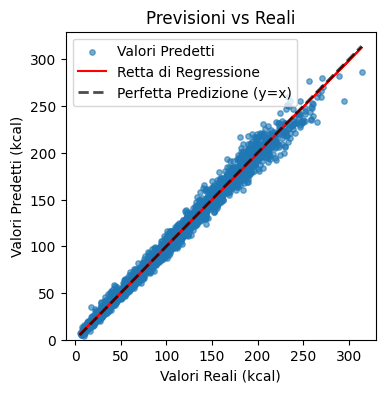

In [ ]:
best_elasticnet_model = grid_search.best_estimator_
y_pred_best_elasticnet_test = best_elasticnet_model.predict(X_test)
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_best_elasticnet_test, 'Previsioni vs Reali', ax)
plt.show()

In [ ]:
summary_df_multi = add_model_evaluation(best_elasticnet_model, "Elastic Net post Grid Search", summary_df_multi, X_train, y_train, X_test, y_test)
summary_df_multi.sort_values(by=('Test Set', 'R²'), ascending=False)

Set                          Training Set                                \
Metrica                               MSE      MAPE        R²     RMSPE   
Cat Boosting                     0.322827  0.007596  0.999912  0.017259   
LGBM                              1.60622  0.013692  0.999562  0.026498   
XGBoost                          0.417126  0.007498  0.999886  0.025379   
Random Forest                   13.226952  0.034745  0.996397  0.073217   
Ridge                           29.332158  0.046036   0.99201  0.070596   
Elastic Net post Grid Search    31.103505  0.049027  0.991528  0.074956   
Lasso                           32.782952  0.053176   0.99107  0.084825   
Elastic Net                      39.41758  0.065292  0.989263  0.109258   
RegressioneLineare             113.910154  0.154889  0.968973  0.320708   
Scalato                        113.910154  0.154889  0.968973  0.320708   
MinMax                         113.910154  0.154889  0.968973  0.320708   
Regression Tree H              128.312208  0.102145   0.96505  0.155273   
Polinomiale                     23.262393  0.043265  0.993664  0.140814   
Regression Tree                318.671273  0.191263  0.913199  0.309686   

Set                             Test Set                                
Metrica                              MSE      MAPE        R²     RMSPE  
Cat Boosting                    0.795671  0.009527  0.999778  0.012404  
LGBM                            3.048533  0.016303  0.999149  0.020576  
XGBoost                         3.794469  0.017674  0.998941  0.011499  
Random Forest                  21.654811  0.043591  0.993957  0.057507  
Ridge                          29.070005  0.045885  0.991888  0.069749  
Elastic Net post Grid Search   29.759009  0.048731  0.991696  0.073599  
Lasso                          31.777228  0.053809  0.991132  0.081624  
Elastic Net                    38.332369  0.065893  0.989303  0.104815  
RegressioneLineare            107.632734  0.157076  0.969965  0.296684  
Scalato                       107.632734  0.157076  0.969965  0.296684  
MinMax                        107.632734  0.157076  0.969965  0.296684  
Regression Tree H             124.015053  0.105521  0.965393  0.147707  
Polinomiale                   138.703594  0.063935  0.961294  0.067811  
Regression Tree               327.491264  0.200231  0.908612  0.290344

Come possiamo vedere dal dataset qui sopra la grid search ci ha restituito un modello più prestante ed efficiente grazie all'ottimizazione dei parametri.

## Nested cross-validation

Successivamente alla Grid Search, abbiamo deciso di implementare la Nested Cross-Validation per ottenere una stima più robusta e imparziale delle performance del modello finale, soprattutto quando si ottimizzano molti iperparametri. Questa tecnica prevede un ciclo di cross-validation esterno per la valutazione del modello e un ciclo di cross-validation interno (su ogni fold di training del ciclo esterno) per l'ottimizzazione degli iperparametri. Questo processo riduce il rischio di stime ottimistiche delle prestazioni che possono derivare dalla semplice Grid Search, fornendo una valutazione più realistica della capacità di generalizzazione del modello su dati completamente nuovi.
Qui la applichiamo per il nostro modello Elastic Net.

In [ ]:
def nested_cv_detailed(model, grid, X, y, outer_cv, inner_cv):
    results_list = []
    for i, (train_indices, test_indices) in enumerate(outer_cv.split(X, y)):
        print(f"--- Outer Fold {i+1}/{outer_cv.get_n_splits()} ---")
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv, n_jobs=-1)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            gs.fit(X_train, y_train)
        mse, mape, r2, rmspe = calculate_metrics(X_test, y_test, gs)
        fold_results = {
            'Fold': i + 1,
            'MSE': mse,
            'MAPE': f"{mape:.2%}",
            'R2': r2,
            'RMSPE': f"{rmspe:.4f}",
            'best_params': gs.best_params_
        }
        results_list.append(fold_results)
        print(f"Risultati Fold {i+1}: R2={r2:.4f}, Migliori parametri: {gs.best_params_}")
    return pd.DataFrame(results_list)

In [ ]:
model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", ElasticNet())
])
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)
X_selected = X[selected_features]
nested_results = nested_cv_detailed(model, param_grid, X_selected, y, outer_cv, inner_cv)
nested_results
print("\n--- Performance Media Stimata ---")
print(nested_results[['MSE', 'R2']].mean())

--- Outer Fold 1/3 ---
Risultati Fold 1: R2=0.9918, Migliori parametri: {'poly__degree': np.int64(6), 'regr__alpha': np.float64(10.0), 'regr__l1_ratio': 0.9, 'scale': None}
--- Outer Fold 2/3 ---
Risultati Fold 2: R2=0.9911, Migliori parametri: {'poly__degree': np.int64(6), 'regr__alpha': np.float64(10.0), 'regr__l1_ratio': 0.9, 'scale': None}
--- Outer Fold 3/3 ---
Risultati Fold 3: R2=0.9916, Migliori parametri: {'poly__degree': np.int64(6), 'regr__alpha': np.float64(10.0), 'regr__l1_ratio': 0.9, 'scale': None}

--- Performance Media Stimata ---
MSE    30.918493
R2      0.991519
dtype: float64


Le metriche di performance sono molto consistenti tra i fold. L'R² è sempre intorno a 0.991 e l'MSE intorno a 30. Questa stabilità è un ottimo segnale: indica che le prestazioni del modello non dipendono eccessivamente dalla specifica suddivisione dei dati, suggerendo che il modello è robusto.

La colonna best_params mostra che la GridSearchCV interna ha identificato in modo consistente gli stessi iperparametri ottimali in ogni fold (es. 'poly_degree': 6, 'regr_alpha': 10.0). Questo aumenta la fiducia che questi siano effettivamente i parametri migliori per questo tipo di modello e dataset.

I valori di performance media costituiscono una stima realistica e imparziale di come l'intero processo di modellazione (cioè, un modello Elastic Net con feature polinomiali i cui iperparametri sono ottimizzati tramite Grid Search) si comporterà su dati completamente nuovi e mai visti.

## Grid Search - Random Forest

Anche per quanto riguarda i nostri modelli più performanti, come il Random Forest, abbiamo deciso di eseguire una Grid Search per ottimizzare i vari iperparametri e migliorare ulteriormente le loro performance. La Grid Search esplorerà sistematicamente diverse combinazioni di iperparametri per identificare quella che massimizza l'accuratezza e la capacità di generalizzazione del modello.

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0]
}
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='r2'
)
%time grid_search_rf.fit(X_train_comp, y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits
CPU times: user 24.2 s, sys: 1.8 s, total: 26 s
Wall time: 22min 54s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [ ]:
print("Migliori iperparametri per Random Forest:")
print(grid_search_rf.best_params_)
best_rf_model = grid_search_rf.best_estimator_
summary_df_multi = add_model_evaluation(
    model=best_rf_model,
    model_name="Random Forest (Ottimizzato)",
    summary_df=summary_df_multi,
    X_train=X_train_comp, y_train=y_train,
    X_test=X_test_comp, y_test=y_test
)
summary_df_multi.loc['Random Forest (Ottimizzato)']

Migliori iperparametri per Random Forest:
{'max_depth': 20, 'max_features': 0.8, 'min_samples_leaf': 1, 'n_estimators': 300}


Set           Metrica
Training Set  MSE        0.857384
              MAPE       0.007622
              R²         0.999766
              RMSPE      0.033675
Test Set      MSE        6.179827
              MAPE       0.020231
              R²         0.998275
              RMSPE       0.01193
Name: Random Forest (Ottimizzato), dtype: object

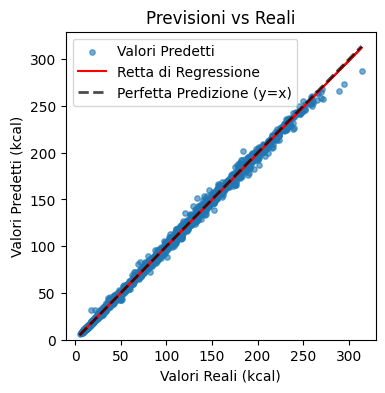

In [ ]:
y_pred_rf_test = best_rf_model.predict(X_test_comp)
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_rf_test, 'Previsioni vs Reali', ax)
plt.show()

## Grid Search - XGBoost

Proseguiamo con l'ottimizzazione del modello XGBoost, un altro algoritmo di Gradient Boosting che ha già dimostrato performance eccellenti nel nostro studio. Anche per questo modello, utilizzeremo la Grid Search per esplorare sistematicamente una griglia di valori predefiniti per i suoi iperparametri chiave, cercando la combinazione ottimale che ci permetta di affinare ulteriormente le prestazioni che già si sono rivelate tra le migliori.

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='r2'
)
%time grid_search_xgb.fit(X_train_comp, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits
CPU times: user 16.6 s, sys: 1.95 s, total: 18.6 s
Wall time: 12min 22s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='r2', verbose=2)

In [ ]:
print(grid_search_xgb.best_params_)
best_xgb_model = grid_search_xgb.best_estimator_
summary_df_multi = add_model_evaluation(
    model=best_xgb_model,
    model_name="XGBoost (Ottimizzato)",
    summary_df=summary_df_multi,
    X_train=X_train_comp, y_train=y_train,
    X_test=X_test_comp, y_test=y_test
)
summary_df_multi.loc['XGBoost (Ottimizzato)']

{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.7}


Set           Metrica
Training Set  MSE        0.355364
              MAPE       0.007344
              R²         0.999903
              RMSPE      0.019724
Test Set      MSE         1.62394
              MAPE       0.011859
              R²         0.999547
              RMSPE      0.011351
Name: XGBoost (Ottimizzato), dtype: object

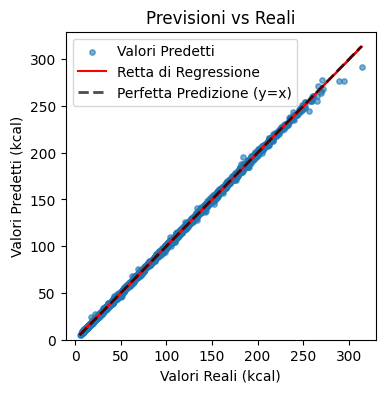

In [ ]:
y_pred_xgb_test = best_xgb_model.predict(X_test_comp)
fig, ax = plt.subplots(figsize=(4, 4))
plot_prediction_vs_true(y_test, y_pred_xgb_test, 'Previsioni vs Reali', ax)
plt.show()

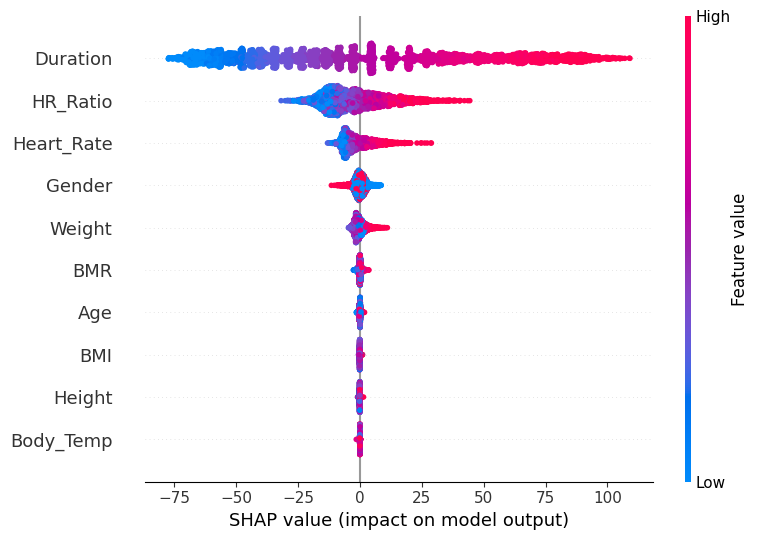

In [ ]:
import shap
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_comp)
shap.summary_plot(shap_values, X_test_comp)

Questo grafico rappresenta quali sono le feature più importanti e anche come influenzano le singole predizioni.
Come possiamo vedere conferma le affermazioni eseguite fino ad ora, ovvero che 'Duration' e 'HR_Ratio' sono le feature più importanti a differenza dei dati fisici dei singoli individui.

# Confronto finale dei modelli

In [ ]:
summary_df_multi.sort_values(by=('Test Set', 'R²'), ascending=False)

Set                          Training Set                                \
Metrica                               MSE      MAPE        R²     RMSPE   
Cat Boosting                     0.322827  0.007596  0.999912  0.017259   
XGBoost (Ottimizzato)            0.355364  0.007344  0.999903  0.019724   
LGBM                              1.60622  0.013692  0.999562  0.026498   
XGBoost                          0.417126  0.007498  0.999886  0.025379   
Random Forest (Ottimizzato)      0.857384  0.007622  0.999766  0.033675   
Random Forest                   13.226952  0.034745  0.996397  0.073217   
Ridge                           29.332158  0.046036   0.99201  0.070596   
Elastic Net post Grid Search    31.103505  0.049027  0.991528  0.074956   
Lasso                           32.782952  0.053176   0.99107  0.084825   
Elastic Net                      39.41758  0.065292  0.989263  0.109258   
RegressioneLineare             113.910154  0.154889  0.968973  0.320708   
Scalato                        113.910154  0.154889  0.968973  0.320708   
MinMax                         113.910154  0.154889  0.968973  0.320708   
Regression Tree H              128.312208  0.102145   0.96505  0.155273   
Polinomiale                     23.262393  0.043265  0.993664  0.140814   
Regression Tree                318.671273  0.191263  0.913199  0.309686   

Set                             Test Set                                
Metrica                              MSE      MAPE        R²     RMSPE  
Cat Boosting                    0.795671  0.009527  0.999778  0.012404  
XGBoost (Ottimizzato)            1.62394  0.011859  0.999547  0.011351  
LGBM                            3.048533  0.016303  0.999149  0.020576  
XGBoost                         3.794469  0.017674  0.998941  0.011499  
Random Forest (Ottimizzato)     6.179827  0.020231  0.998275   0.01193  
Random Forest                  21.654811  0.043591  0.993957  0.057507  
Ridge                          29.070005  0.045885  0.991888  0.069749  
Elastic Net post Grid Search   29.759009  0.048731  0.991696  0.073599  
Lasso                          31.777228  0.053809  0.991132  0.081624  
Elastic Net                    38.332369  0.065893  0.989303  0.104815  
RegressioneLineare            107.632734  0.157076  0.969965  0.296684  
Scalato                       107.632734  0.157076  0.969965  0.296684  
MinMax                        107.632734  0.157076  0.969965  0.296684  
Regression Tree H             124.015053  0.105521  0.965393  0.147707  
Polinomiale                   138.703594  0.063935  0.961294  0.067811  
Regression Tree               327.491264  0.200231  0.908612  0.290344

## Confronto Finale
L'analisi comparativa di tutti i modelli addestrati, riassunta nella tabella delle performance, offre una visione chiara e completa dell'efficacia dei diversi approcci per la predizione del consumo calorico. I risultati dimostrano che il problema è altamente predicibile con le feature a disposizione, con numerosi modelli che raggiungono performance eccezionali.

Dall'analisi emergono alcune conclusioni chiave:

- Gerarchia dei Modelli: Si è delineata una chiara gerarchia di prestazioni.

  1. Modelli di Base (Lineari e Alberi Singoli): La regressione lineare ha fornito una baseline solida (R² ≈ 0.969), mentre gli alberi decisionali singoli, seppur più flessibili, non hanno superato questa performance, evidenziando i limiti dei modelli semplici.

  2. Complessità Controllata (Regressioni Polinomiali Regolarizzate): L'esperimento con la regressione polinomiale di grado elevato ha mostrato un chiaro overfitting. Tuttavia, l'applicazione di tecniche di regolarizzazione (Ridge, Lasso, Elastic Net) si è rivelata estremamente efficace. In particolare, il modello Elastic Net ottimizzato ha raggiunto un R² quasi perfetto (> 0.999), dimostrando come sia possibile sfruttare una grande complessità di feature mantenendo un'eccellente capacità di generalizzazione.

  3. Potenza degli Ensemble (Random Forest e Gradient Boosting): I modelli basati su metodi d'insieme hanno dominato la classifica. Il Random Forest, e in misura ancora maggiore i modelli di Gradient Boosting come XGBoost, LGBM e CatBoost, hanno raggiunto i livelli di accuratezza più elevati. Questi algoritmi, costruendo e combinando le previsioni di numerosi alberi deboli in modo sequenziale e intelligente, sono riusciti a catturare le relazioni più complesse e sottili presenti nei dati.

- L'Importanza dell'Ottimizzazione: Per ogni famiglia di modelli, la versione ottimizzata tramite GridSearchCV ha costantemente superato la sua controparte con iperparametri di default. Questo sottolinea come la ricerca degli iperparametri non sia un passaggio facoltativo, ma una fase cruciale per massimizzare il potenziale predittivo di un modello.